# Start

In [1]:
memory_size = 200
history = memory_size
device =  'cuda:1'
debug = False
reward_list = []
train_episode_length = memory_size // 4 # 고로 4번의 senario를 볼 수 있도록 함.
model_update_count = memory_size
sample_batch_size = 50
epoch_length = 100
start_step = 20
end_step = 5

In [2]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import math
import torch

''' Replay Buffer
'''
N_CHANNEL, N_HIGH, N_WEIGHT = 50, 240, 240
# ReplayMemory의 역할은 state, action, reward, next_state를 저장하는 것
# state, action, reward, next_state를 저장해서 학습할 때 사용함.
class ReplayMemory():
    def __init__(self, memory_size):
        # self.memory의 역할은 state, action, expected_reward, next_state를 저장하는 것
        self.memory_counter = 0
        self.memory_size = memory_size
        self.state_memory = torch.FloatTensor(self.memory_size, 1, N_CHANNEL, N_HIGH, N_WEIGHT)
        self.action_memory = torch.LongTensor(self.memory_size)
        self.reward_memory = torch.FloatTensor(self.memory_size)
        self.state__memory = torch.FloatTensor(self.memory_size, 1, N_CHANNEL, N_HIGH, N_WEIGHT)

    def store(self, s, a, r, s_):
        # 여기를 보면 index에 맞게 "순서대로" 저장하는 것을 볼 수 있음.ㅅ 
        index = self.memory_counter % self.memory_size
        # if debug:
            # print(index, "- (ReplayMemory.store)index")
        # print(s.shape, "- (ReplayMemory.store)s.shape")
        self.state_memory[index] = s
        self.action_memory[index] = torch.LongTensor([a.tolist()])
        self.reward_memory[index] = torch.FloatTensor([r])
        self.state__memory[index] = s_
        self.memory_counter += 1

    def sample(self, size):
        sample_index = np.random.choice(self.memory_size, size)
        state_sample = torch.FloatTensor(size,1,  N_CHANNEL, N_HIGH, N_WEIGHT)
        action_sample = torch.LongTensor(size, 1)
        reward_sample = torch.FloatTensor(size, 1)
        state__sample = torch.FloatTensor(size, 1, N_CHANNEL, N_HIGH, N_WEIGHT)
        for index in range(sample_index.size):
            state_sample[index] = self.state_memory[sample_index[index]]
            action_sample[index] = self.action_memory[sample_index[index]]
            reward_sample[index] = self.reward_memory[sample_index[index]]
            state__sample[index] = self.state__memory[sample_index[index]]
        return state_sample.to(device), action_sample.to( device), reward_sample.to( device), state__sample.to( device)


''' Reshape state patches to full size input 50 x 256 x 256
'''
# crop_reshape 함수는 3D image를 (channel, 256, 256)으로 확장시키는 함수
# TODO: 이거 시발 왜 하는거
def crop_reshape(img, x,y,z,w,h,d):
    img = np.array(img)
    new_image = []
    image_patch = img[x:x+h, y:y+w, z:z+d]
    for i in range(image_patch.shape[2]):
        new_image.append(cv2.resize(image_patch[:, :, i], (240, 240)))
    new_image = np.array(new_image)
    return_image = torch.tensor(new_image.reshape(1,1,new_image.shape[0], new_image.shape[1], new_image.shape[2])).float()
    # if debug:
        # print(new_image.shape, "- (crop_reshape)new_image.shape")
        # print(return_image.shape, "- (crop_reshape)return_image.shape")
    return return_image

'''Compute Accuracy for Training 
'''

# binary_acc함수는 y_pred와 y_test를 받아서 정확도를 계산하는 함수
def binary_acc(y_pred, y_test):
    #y_pred[y_pred >= 0.5] = 1 
    #y_pred[y_pred < 0.5] = 0
    _, y_pred = y_pred.max(1)
    correct_results_sum = (y_pred == y_test).sum().float()
    acc = correct_results_sum#/y_test.shape[0]
    acc = torch.round(acc)

    return acc

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3Dmodels  

<img src="./src/DQN_based_Localization_figure.png" alt="Description of the image" width="600" height="400"/>

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d,MaxUnpool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from skimage import util
from torchvision import transforms, models
from torch import optim

import numpy as np
import random
import torchvision
from collections import namedtuple, deque
import math

# DQNSolver함수는 3D image를 받아서 7개의 action을 출력하는 DQN 모델을 생성하는 함수
# DQN이란 Deep Q Network의 약자로 Q-learning을 딥러닝으로 구현한 것
# 현재는 50, 256, 256의 3D image를 받아서 7개의 action을 출력하는 모델을 생성함.
# 근데 우리의 Data는 50, 240, 240의 shape이기 때문에 이 부분을 수정해야함.
class DQNSolver(nn.Module):
    """
    Convolutional Neural Net with 3 conv3D layers and two linear layers
    """
    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(input_shape[0], 32, kernel_size=(5,5,5), stride=2),
            nn.LeakyReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(32, 64, kernel_size=(5,5,5), stride=1),
            nn.LeakyReLU(),
            nn.MaxPool3d((1, 2, 2)),
            nn.Conv3d(64, 64, kernel_size=(3,3,3), stride=2),
            nn.LeakyReLU(),
            nn.MaxPool3d((2, 2, 2)),
        )
        
        # conv_out_size의 역할은 conv layer를 거치고 나온 output의 size를 계산하는 것
        # _get_conv_out에 어떤 shape이 들어가냐면, 
        # DQNSolver의 예상 input_shape의 크기가 (1,50,256,256)라면
        # DQNSolver의 예상 input_shape은 (1, 50, 240, 240)라면, output의 shape은 (1, 64, 3, 3, 3)이 됨.
        # 즉, 64 * 3 * 3 * 3 = 1728이 됨.
        # 이걸 self.fc layer를 이용해 7개로 줄여 action을 결정하게 됨.
        # 여기서 7개의 액션은 각각의 방향으로 움직이는 것을 의미함.
        # 0 - up, 1- down, 2 - right, 3- left, 4- top, 5 - bottom, 6 - terminate
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        # print(conv_out.size(), "- DQNSolver.conv_out size")
        return self.fc(conv_out)


class Classifier(nn.Module):
    """
    Convolutional Neural Net with 3 conv3D layers and two linear layers
    """
    def __init__(self, input_shape, num_features):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(input_shape[0], 32, kernel_size=(5,5,5), stride=2),
            nn.LeakyReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(32, 64, kernel_size=(5,5,5), stride=1),
            nn.LeakyReLU(),
            nn.MaxPool3d((1, 2, 2)),
            nn.Conv3d(64, 64, kernel_size=(3,3,3), stride=2),
            nn.LeakyReLU(),
            nn.MaxPool3d((2, 2, 2)),
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_features),
            nn.ReLU()
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        # print(conv_out.size(), "- Classifier.conv_out size")
        return self.fc(conv_out)

# concat_
class concat_classifier(nn.Module):
    def __init__(self, input_shape1,input_shape2, classes):
        super(concat_classifier, self).__init__()

        input_shape = input_shape1[1] + input_shape2[1] 
        self.fc = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, classes),
            nn.Sigmoid()
            )

    def forward(self,x1, x2):
        cat_out = torch.cat((x1,x2), dim = 1)
        output = self.fc(cat_out)
        return output


class combine_model(nn.Module):
    def __init__(self, model1, model2, model3):
        super(combine_model, self).__init__()

        self.model1 = model1
        self.model2 = model2
        self.model3 = model3

    def forward(self, x1, x2):
        input1 = x1
        input2 = x2

        out1 = self.model1(input1)
        out2 = self.model2(input2)
        pred = self.model3(out1, out2)

        return pred

# 우리 데이터의 input shape이 어떻게 되는지 확인해야함
policy_model = DQNSolver((1,50,240,240), 7).to( device)
target_model = DQNSolver((1,50,240,240), 7).to( device)

# hippocampus는 3D shape이 50, 256, 256인 이미지를 받아서 512개의 feature로 변환
# hippocampus란 해마를 의미함.
# classifier_hippocampus = Classifier((1,50,256,256), 512)

# global은 3D shape이 145, 256, 256인 이미지를 받아서 1024개의 feature로 변환
# TODO: 둘 차이가 많이 나는데 이게 맞는건지 확인
# classifier_global = Classifier((1,145,256,256), 1024)
# final_model = concat_classifier((1,512), (1, 1024), 2)

# final_model이 2개의 feature를 받아서 2개의 class로 분류하는 모델
# 현재의 프로젝트 맥락에서 각각은 AD, CN을 의미함.
# 여기서 AD는 Alzheimer's Disease, CN은 Control을 의미함.
# class_model = combine_model(classifier_hippocampus, classifier_global, final_model)

# DQN_agent

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d,MaxUnpool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD, AdamW
from skimage import util
from torchvision import transforms, models
from torch import optim

from medpy.io import load
import cv2

''' DQN Agent
'''
class DQNAgent(object):
    def __init__(self, policy_model, target_model, replay_memory):
            self.batch_size = sample_batch_size
            self.gamma = 0.99
            self.eps = 1
            self.target_update = 0
            screen_height, screen_width, screen_depth = 240, 240, 150
            self.n_actions = 7
            self.policy_model = policy_model
            self.target_model = target_model
            self.target_model.eval()
            # self.optimizer = optim.SGD(self.policy_model.parameters(), lr = 0.00009)
            self.optimizer = optim.Adam(self.policy_model.parameters(), lr = 0.01)
            self.loss_func = torch.nn.SmoothL1Loss()#nn.MSELoss()
            self.memory = replay_memory

    ''' Compute reward with L2 distance between centers of state and gd
    '''
    def compute_reward(self, actual_state, prev_state, ground_truth, threshold):
            x,y,z,w,h,d = actual_state
            x_p,y_p,z_p,w_p,h_p,d_p = prev_state
            x_gd, y_gd, z_gd, w_gd, h_gd, d_gd = ground_truth

            center = np.array([(x+w)/2,(y+h)/2, (z+d)/2])
            center_gd = np.array([(x_gd + w_gd)/2,(y_gd + h_gd)/2, (z_gd + d_gd)/2])
            center_p = np.array([(x_p + w_p)/2,(y_p + h_p )/2, (z_p + d_p)/2])
            dist_l2 = np.linalg.norm(center - center_gd)
            dist_l2_p = np.linalg.norm(center_p - center_gd)

            if dist_l2 < threshold:
                game = "END"
                reward = 100
                return game, reward
            else:
                game = "continue"
                reward = min(-1, -dist_l2) #dist_l2 - dist_l2_p #
                # if debug:
                # print(dist_l2, reward, min(1, -dist_l2), " - dist_l2, reward, min(1, -dist_l2)")
                return game, reward

    ''' 0 - up, 1- down, 2 - right, 3- left, 4- top, 5 - bottom, 6 - terminate
    '''
    
    def next_state(self, prev_state, action, step):
        x, y, z, w, h, d = prev_state
        max_x, max_y, max_z = 240, 240, 150
        min_x, min_y, min_z = 0, 0, 0
        def bounded_move(value, delta, min_val, max_val, size):
            new_value = value + delta * step
            return max(min_val, min(new_value, max_val - size))
    # 경계값을 검사하고 위치를 업데이트하는 함수

    # 각 액션에 따른 위치 업데이트
        if action == 0:  # Move right
            x = bounded_move(x, 1, min_x, max_x, w)
        elif action == 1:  # Move left
            x = bounded_move(x, -1, min_x, max_x, w)
        elif action == 2:  # Move up
            y = bounded_move(y, 1, min_y, max_y, h)
        elif action == 3:  # Move down
            y = bounded_move(y, -1, min_y, max_y, h)
        elif action == 4:  # Move forward
            z = bounded_move(z, 1, min_z, max_z, d)
        elif action == 5:  # Move back
            z = bounded_move(z, -1, min_z, max_z, d)

        return [int(x),int(y),int(z),int(w),int(h),int(d)]
    # def next_state(self, prev_state, actn, step):
    #     # TODO: 일단 우리 data는 240x240x155이므로 그에 맞게 코드를 수정하던가 우리의 데이터를 interpolation해야할 듯 함.
    #     # 근데 이미 interpolation하는 코드가 있어서, 그걸 사용하면 될 듯함.
    #     x,y,z,w,h,d = prev_state
    #     # max_x:가 왜 255인지 모르겠음
    #     max_x = 240
    #     max_y = 240
    #     max_z = 150
    #     min_x = 0
    #     min_y = 0
    #     min_z = 0
        
    #     if actn == 0 and x + w + step < max_x:
    #         x = x + step
    #     elif actn == 1 and x - step > 0:
    #         x = x - step
    #     elif actn == 2: and y + h + step < max_y:
    #         y = y + step
    #     elif actn == 3 and y - step > 0:
    #         y = y - step
    #     elif actn == 4 and z + d + step < max_z :
    #         z = z + step
    #     elif actn == 5 and z - step > 0:
    #         z = z - step

        # if actn == 0:
        #     if x + w + step >= max_x:
        #         x = x
        #     else:
        #         x = x + step
        # elif actn == 1:
        #     if x - step <= 0:
        #         x = 100
        #     else:
        #         x = x - step
        # elif actn == 2:
        #     if y + h + step >= max_y:
        #         y = 100
        #     else:
        #         y = y + step
        # elif actn == 3:
        #     if y - step <= 0:
        #         y = 100
        #     else:
        #         y = y - step
        # elif actn == 4:
        #     if z + d + step >= max_z :
        #         z = 50
        #     else:
        #         z = z + step
        # elif actn == 5:
        #     if z - step <= 0:
        #         z = 50
        #     else:
        #         z = z - step
        # return [int(x),int(y),int(z),int(w),int(h),int(d)]
    # def next_state(self, prev_state, actn, step):
    #     # Constants for boundaries
    #     max_bounds = {'x': 240, 'y': 240, 'z': 150}
    #     min_bounds = {'x': 0, 'y': 0, 'z': 0}
        
    #     x, y, z, w, h, d = prev_state

    #     # Action mapping
    #     actions = {
    #         0: ('x', step, max_bounds['x'], 100),
    #         1: ('x', -step, min_bounds['x'], 100),
    #         2: ('y', step, max_bounds['y'], 100),
    #         3: ('y', -step, min_bounds['y'], 100),
    #         4: ('z', step, max_bounds['z'], 50),
    #         5: ('z', -step, min_bounds['z'], 50)
    #     }
        
    #     # Get the corresponding parameters for the action
    #     axis, movement, bound, reset_value = actions[int(actn.item())]
        
    #     # Apply the movement and boundary checks
    #     if axis == 'x':
    #         x = self.update_coordinate(x, movement, bound, reset_value)
    #     elif axis == 'y':
    #         y = self.update_coordinate(y, movement, bound, reset_value)
    #     elif axis == 'z':
    #         z = self.update_coordinate(z, movement, bound, reset_value)
        
    #     return [int(x),int(y),int(z),int(w),int(h),int(d)]

    # def update_coordinate(self, coord, movement, bound, reset_value):
    #     new_coord = coord + movement
    #     if movement > 0:  # Moving forward
    #         if new_coord >= bound:
    #             return reset_value
    #     else:  # Moving backward
    #         if new_coord <= bound:
    #             return reset_value
    #     return new_coord


    ''' Start with high eps then reduce eps, if game = END then action should be 6
    '''
    # epsilon-greedy 방법을 이용해서 action을 선택하는 함수
    def select_action(self, state, game, eps ):
        # print(state.device, " - state.device")
        actn = 6
        if game == "continue":
            sample = random.random()
            if sample < eps:
                actn = np.asarray(random.randrange(6))
                actn = torch.tensor(actn)

            else:
                # state의 예상 shape은 (1, 50, 240, 240)이 됨.
                # print(state.shape, "- state shape")
                out = self.policy_model(state)
                _, actn = torch.max(out.data, 1)

            # print(actn.device)
            actn = np.array(actn.cpu())
            return actn
        else:
            actn = np.array(actn.cpu())
            return actn

    def select_action_test(self, state):
        out = self.target_model(state)
        _, actn = torch.max(out.data,1)
        return actn

    def store_transition(self, s, a, r, s_):
            self.memory.store(s, a, r, s_)

    ''' Optimize model with replay memory
    '''

    def optimize(self, counter):

        if self.target_update > counter:
            self.target_model.load_state_dict(self.policy_model.state_dict())
            self.target_update = 0
            print("Updating Target Net")

        self.target_update += 1


        s_s, a_s, r_s, s__s = self.memory.sample(self.batch_size)
        # policy_model의 output은 7개의 action에 대한 expected reward를 출력함.
        q_eval = self.policy_model(s_s).gather(1, a_s)
        q_next = self.target_model(s__s).detach()
        q_target = r_s + self.gamma * q_next.max(1)[0].view(self.batch_size, 1)
        # if debug:
            # print(s_s.shape, a_s.shape, r_s.shape, s__s.shape, " - s_s.shape, a_s.shape, r_s.shape, s__s.shape")
            # print(q_eval, q_target, "q_eval, q_target")
            # print(q_eval.shape, q_target.shape, "q_eval.shape, q_target.shape")
        loss = self.loss_func(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss

my_dqn = DQNAgent(policy_model, target_model, ReplayMemory(memory_size))

# Custom Data Gen

In [5]:
DATA_PATH = '../archive_BraTS2022'
TRAIN_PATH = f'{DATA_PATH}/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
TEST_PATH = f'{DATA_PATH}/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
DATA_TYPES = ['flair', 't1', 't1ce', 't2', 'seg']
N_FOLDS = 5

In [6]:
# import os
# import nibabel as nib
# from glob import glob
# import re
# from tqdm.auto import tqdm

# def load_brats_data(path):
#     print('load_brats_data...')
#     files_path = []
#     mask_paths = []
#     unique_id = []
#     for file_path in glob(f'{path}/*/*.nii'):
#         # t1 파일만 처리
#         if re.search(r"_t1(?=\.)", file_path):
#             files_path.append(file_path)
#         # seg 파일만 처리
#         if "seg" in file_path:  # segmentation mask file
#             mask_paths.append(file_path)
#         unique_id.append(str(int(file_path.split('_')[-2])))
#     print(len(files_path), len(mask_paths), len(unique_id), " - len(files_path), len(mask_paths), len(unique_id)")
#     print(files_path[:2], mask_paths[:2], unique_id[:2], " - files_path, mask_paths, unique_id")
#     print("load_brats_data done.")
#     return sorted(files_path), sorted(mask_paths), sorted(list(set(unique_id)), key=lambda x: int(x))

# var1 = 0
# var2 = 150
# def compute_brats_masks(mask_paths, var1, var2):
#     print('compute_brats_masks...')
#     all_masks = []
#     for mask_path in tqdm(mask_paths):
#         mask = nib.load(mask_path).get_fdata()  # 마스크 데이터 로드
#         dummy_var = []
#         for j in range(min(var2, mask.shape[-1])):
#             if j <= var2:  # 주어진 범위 내의 슬라이스만 처리
#                 msk = mask[:, :, j] / mask.max() * 255  # 슬라이스 정규화 및 스케일링(0 ~ 1)
#                 # msk = cv2.resize(msk, (256, 256))  # 이미지 크기 조정
#                 _, bw_img = cv2.threshold(msk.astype(np.uint8), 10, 255, cv2.THRESH_OTSU)  # 이진화
#                 contours, _ = cv2.findContours(bw_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)  # 컨투어 찾기
                
#                 # 가장 큰 컨투어 찾기
#                 max_area = 0
#                 max_rect = (0, 0, 0, 0)
#                 for contour in contours:
#                     rect = cv2.boundingRect(contour)
#                     area = rect[2] * rect[3]  # rectangle의 넓이 (width * height)
#                     if area > max_area:
#                         max_area = area
#                         max_rect = rect
                
#                 # 가장 큰 컨투어의 사각형 정보 저장
#                 if max_area > 0:
#                     dummy_var.append([j, max_rect])
#                 else:
#                     dummy_rect = [0, 0, 0, 0]  # 컨투어가 없을 경우
#                     dummy_var.append([j, dummy_rect])
#         all_masks.append(dummy_var)
    
#     # np_all_masks는 단순히 shape을 위해 만든 것
#     np_all_masks = np.array(all_masks, dtype=object)
#     print(np_all_masks.shape, " - np_all_masks.shape")
#     print("compute_brats_masks done.")
#     return all_masks


# def brats_markers(slices_mask):
#     print('brats_markers...')
#     marks = []
#     for i in tqdm(range(len(slices_mask))):
#         x_min = []
#         y_min = []
#         w_max = []
#         h_max = []
#         indx_diff = []
#         for j in range(len(slices_mask[i])):
#             x_min.append(slices_mask[i][j][1][0])
#             y_min.append(slices_mask[i][j][1][1])
#             w_max.append(slices_mask[i][j][1][2])
#             h_max.append(slices_mask[i][j][1][3])

#             if slices_mask[i][j][1][0] != 0:
#                 indx_diff.append(slices_mask[i][j][0])
#         x_min = np.array(x_min)
#         y_min = np.array(y_min)
#         x_mn = np.min(x_min[np.nonzero(x_min)])
#         y_mn = np.min(y_min[np.nonzero(y_min)])
#         w_mx = np.array(w_max).max()
#         h_mx = np.array(h_max).max()
#         dim = [x_mn, y_mn, w_mx, h_mx]
#         d_mx = indx_diff[-1] - indx_diff[0]
#         z_mn = indx_diff[0]
#         marks.append([x_mn, y_mn, z_mn, w_mx, h_mx, d_mx])
#     print(marks[:2], " - marks[:2]")
#     print("brats_markers done.")
#     return marks

# all_files_id, mask_paths, unique_id = load_brats_data(TRAIN_PATH)
# sliced_masks = compute_brats_masks(mask_paths, var1, var2)
# sliced_markers = brats_markers(sliced_masks)
# print(sliced_masks[:2], sliced_markers[:2], " - sliced_masks, sliced_markers")
# # # Create labels (example: 1 for tumor presence, 0 for no tumor)
# # labels = np.ones((len(sliced_markers), 1))  # Assuming all masks are tumors

# # label_data = np.hstack([sliced_markers, labels])


# Data_Prep - Original

In [7]:
# import glob
# import numpy as np
# import random
# import fnmatch
# import os
# from PIL import Image
# from matplotlib import pyplot as plt
# import PIL
# from sklearn.model_selection import train_test_split
# from sklearn.decomposition import PCA
# #from tensorflow.keras.utils import to_categorical
# from sklearn.metrics import confusion_matrix

# from bs4 import BeautifulSoup
# from medpy.io import load
# import cv2

# from collections import namedtuple, deque
# import math
# from sklearn.utils import shuffle
# from tqdm import tqdm

# ''' Read files for AD and CN
# '''

# # def mask_load(path):
#     # files_id = []
#     # mask = []
#     # unique_id = []
#     # for root, folder, file in os.walk(os.path.abspath(path)):
#     #     for masks in fnmatch.filter(file,"*.nii"):
#     #         y = os.path.join(root, masks).rsplit("\\")[6]
#     #         uid = os.path.join(root, masks).rsplit("\\")[8]
#     #         mask.append(os.path.join(root, masks))
#     #         files_id.append(y)
#     #         unique_id.append(uid)
#     # return files_id, mask, unique_id

# # path_ad = "Path to AD\\ADNI"
# # all_files_ad_id, mask_ad, ad_unique_id = mask_load(path_ad)

# # path_cn = "Path to \\CN\\ADNI"
# # all_files_cn_id, mask_cn, cn_unique_id = mask_load(path_cn)


# brats_file_paths, brats_mask_paths, brats_unique_id = load_brats_data(TRAIN_PATH)
# #MP-RAGE_, SAG_MP-RAGE, MP-RAGE-, MPRAGE, MPRAGE_, MP-RAGE

# # def data_load(path, file_id, unique_id):
# #   file_path = []
# #   f_path = []
# #   for root, folder, file in os.walk(os.path.abspath(path)):
# #     f_path = []
# #     for filename in fnmatch.filter(file, "*.dcm" ):
# #       id1 = os.path.join(root, filename).rsplit("\\")[6]
# #       if id1 in file_id:
# #           id2 = os.path.join(root, filename).rsplit("\\")[8]
# #           if id2 in unique_id:
# #               x = os.path.join(root, filename).rsplit("\\")[7]
# #               if (x == "MP-RAGE_" or x == "SAG_MP-RAGE" or x == "MP-RAGE-" or
# #                    x == "MPRAGE" or x == "MPRAGE_" or x == "MP-RAGE") :
# #                        f_path.append(os.path.join(root, filename))

# #     if len(f_path) != 0:
# #         file_path.append(f_path)
# #   return file_path

# # all_files_ad = data_load(path_ad, all_files_ad_id, ad_unique_id )

# # def data_load_cn(path, file_id, unique_id):
# #   file_path = []
# #   f_path = []
# #   for root, folder, file in os.walk(os.path.abspath(path)):
# #     f_path = []
# #     for filename in fnmatch.filter(file, "*.dcm" ):
# #       id1 = os.path.join(root, filename).rsplit("\\")[6]
# #       if id1 in file_id:
# #           id2 = os.path.join(root, filename).rsplit("\\")[8]
# #           if id2 in unique_id:
# #               x = os.path.join(root, filename).rsplit("\\")[7]
# #               if ( x == "MP-RAGE_" or x == "MP-RAGE-" or x == "MPRAGE" or
# #                    x == "SAG_MP-RAGE_" or x == "MPRAGE_" or x == "MP_RAGE" or
# #                    x == "MP-RAGE" or x == "MP-RAGE_" or x == "MP-RAGE__SERIES_2_" or
# #                    x == "SAG_MP-RAGE") :
# #                        f_path.append(os.path.join(root, filename))

# #     if len(f_path) != 0:
# #         file_path.append(f_path)
# #   return file_path

# # all_files_cn = data_load_cn(path_cn, all_files_cn_id, cn_unique_id)

# ''' Choose slices 25 - 125
# '''
# # 원래는 slice마다 image가 있어서, 이걸 전부 붙이는 과정이 있었는 듯 함.
# var1 = 15
# var2 = 159
# # def slice_select(var1, var2, file_path):
# #     new_filepath = []
# #     for i in range(len(file_path)):
# #         dummy_var = []
# #         for j in range(len(file_path[i])):
# #             if j>=var1 and j<= var2:
# #                 dummy_var.append(file_path[i][j])
# #         new_filepath.append(dummy_var)
# #     return new_filepath

# # sliced_all_files_cn = slice_select(var1, var2, all_files_cn)
# # sliced_all_files_ad = slice_select(var1, var2, all_files_ad)

# ''' mask selection
# '''

# def compute_all_masks(var1, var2, file):
#     all_masks = []
#     for i in range(len(file)):
#         mask1,_ = load(file[i])
#         dummy_var = []
#         for j in range(mask1.shape[0]):
#             if j >= var1 and j <= var2:
#                 msk = 255*mask1[j]/mask1[j].max()
#                 msk = cv2.resize(msk, (256,256))
#                 _, bw_img = cv2.threshold(msk.astype(np.uint8), 10, 255, cv2.THRESH_OTSU)
#                 # _, bw_img = cv2.threshold(masks[indx_mx], 127, 255, cv2.THRESH_BINARY)
#                 contours,_ = cv2.findContours(bw_img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
#                 if len(contours) != 0:
#                     # TODO: contours에서 가장 큰 것을 rect에 저장되도록 코드 수정.
#                     # 그래서 2D image마다 contours를 찾아서 저장하고 있음, 이를 수정해야함.
#                     rect =  cv2.boundingRect(contours[0])
#                     dummy_var.append([j, rect])
#                 else:
#                     dummy_rect = [0,0,0,0]
#                     dummy_var.append([j, dummy_rect])

#         all_masks.append(dummy_var)
#     return all_masks

# def compute_all_brats_masks(var1, var2, file):
#     all_masks = []
#     for i in range(len(file)):
#         mask1,_ = load(file[i])
#         dummy_var = []
#         for j in range(mask1.shape[0]):
#             if j >= var1 and j <= var2:
#                 msk = 255*mask1[j]/mask1[j].max()
#                 msk = cv2.resize(msk, (256,256))
#                 _, bw_img = cv2.threshold(msk.astype(np.uint8), 10, 255, cv2.THRESH_OTSU)
#                 # _, bw_img = cv2.threshold(masks[indx_mx], 127, 255, cv2.THRESH_BINARY)
#                 contours,_ = cv2.findContours(bw_img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
#                 if len(contours) != 0:
#                     # TODO: contours에서 가장 큰 것을 rect에 저장되도록 코드 수정.
#                     # 그래서 2D image마다 contours를 찾아서 저장하고 있음, 이를 수정해야함.
#                     rect =  cv2.boundingRect(contours[0])
#                     dummy_var.append([j, rect])
#                 else:
#                     dummy_rect = [0,0,0,0]
#                     dummy_var.append([j, dummy_rect])

#         all_masks.append(dummy_var)
#     return all_masks


# # mask_cn의 예상 입력은 file_paths이다. 
# # sliced_masks_cn = compute_all_masks(var1, var2, mask_cn)
# # sliced_masks_ad = compute_all_masks(var1, var2, mask_ad)


# brats_sliced_masks = compute_all_masks(var1, var2, brats_mask_paths)

# ''' Select mask dimension and markers for Hippocampus region
# '''
# def markers(slices_mask):
#     marks = []
#     for i in range(len(slices_mask)):
#         x_min = []
#         y_min = []
#         w_max = []
#         h_max = []
#         z_mn = 0
#         indx_diff = []
#         for j in range(len(slices_mask[i])):
#             x_min.append(slices_mask[i][j][1][0])
#             y_min.append(slices_mask[i][j][1][1])
#             w_max.append(slices_mask[i][j][1][2])
#             h_max.append(slices_mask[i][j][1][3])

#             if slices_mask[i][j][1][0] != 0:
#                 indx_diff.append(slices_mask[i][j][0])
#         x_min = np.array(x_min)
#         y_min = np.array(y_min)
#         x_mn = np.min(x_min[np.nonzero(x_min)])
#         y_mn = np.min(y_min[np.nonzero(y_min)])
#         w_mx = np.array(w_max).max()
#         h_mx = np.array(h_max).max()
#         dim = [x_mn, y_mn, w_mx, h_mx]
#         # print(dim)
#         d_mx = indx_diff[-1] - indx_diff[0]
#         # print(diff)
#         z_mn = indx_diff[0]
#         marks.append([x_mn, y_mn, z_mn, w_mx, h_mx , d_mx])
#     return marks

# sliced_markers_cn = markers(sliced_masks_cn)
# sliced_markers_ad = markers(sliced_masks_ad)

# ''' Concat labels 1 - AD,  0 -  CN
# '''
# labels_ad = np.ones((len(sliced_markers_ad),1))
# labels_cn = np.zeros((len(sliced_markers_cn),1))

# label_cn = np.hstack([sliced_markers_cn, labels_cn])
# label_ad = np.hstack([sliced_markers_ad, labels_ad])


# class data_cleaning_concat():
#     def __init__(self, data1, data2, label1, label2):
#         self.data1 = data1
#         self.data2 = data2
#         self.label1 = label1
#         self.label2 = label2

#     def _index_values(self, dataset):
#         index = []
#         for i in range(len(dataset)):
#             if len(dataset[i]) < 145:
#                 index.append(i)
#         return index

#     def _pop_list(self, dataset, label, index):
#         for i in range(len(index)):
#             dataset.pop(index[i])
#             label.pop(index[i])
#         return dataset, label

#     def files_concat(self):
#         concat_data = []
#         concat_label = []

#         data1_ , label1_ = self._pop_list(self.data1, self.label1, self._index_values(self.data1))
#         data2_ , label2_ = self._pop_list(self.data2, self.label2, self._index_values(self.data2))

#         for i in range(len(data1_)):
#             concat_data.append(data1_[i])
#             concat_label.append(label1_[i])

#         for j in range(len(data2_)):
#             concat_data.append(data2_[j])
#             concat_label.append(label2_[j])

#         return shuffle(concat_data, concat_label)




# data_clean = data_cleaning_concat(sliced_all_files_ad, sliced_all_files_cn,
#                                                 list(label_ad) , list(label_cn))
# total_data , total_label = data_clean.files_concat()

# def cross_valid_splits(data, label, fold):
#     fold_train = []
#     fold_test = []
#     fold_ytrain = []
#     fold_ytest = []

#     indxs1 = int(1*len(data)/5)
#     indxs2 = int(2*len(data)/5)
#     indxs3 = int(3*len(data)/5)
#     indxs4 = int(4*len(data)/5)
#     indxs5 = int(5*len(data)/5)

#     rn_trn = []
#     rn_tst = []
#     if fold == 1:
#         for i in range(0, indxs4):
#             fold_train.append(data[i])
#             fold_ytrain.append(label[i])

#         for j in range(indxs4, indxs5):
#             fold_test.append(data[j])
#             fold_ytest.append(label[j])

#     elif fold == 2:
#         for i in range(0, indxs3):
#             fold_train.append(data[i])
#             fold_ytrain.append(label[i])
#         for i in range(indxs4,indxs5):
#             fold_train.append(data[i])
#             fold_ytrain.append(label[i])


#         for j in range(indxs3, indxs4):
#             fold_test.append(data[j])
#             fold_ytest.append(label[j])

#     elif fold == 3:
#         for i in range(0, indxs2):
#             fold_train.append(data[i])
#             fold_ytrain.append(label[i])
#         for i in range(indxs3,indxs5):
#             fold_train.append(data[i])
#             fold_ytrain.append(label[i])


#         for j in range(indxs2, indxs3):
#             fold_test.append(data[j])
#             fold_ytest.append(label[j])


#     elif fold == 4:
#         for i in range(0, indxs1):
#             fold_train.append(data[i])
#             fold_ytrain.append(label[i])
#         for i in range(indxs2,indxs5):
#             fold_train.append(data[i])
#             fold_ytrain.append(label[i])


#         for j in range(indxs1, indxs2):
#             fold_test.append(data[j])
#             fold_ytest.append(label[j])


#     elif fold == 5:
#         for i in range(indxs1, indxs5):
#             fold_train.append(data[i])
#             fold_ytrain.append(label[i])

#         for j in range(0, indxs1):
#             fold_test.append(data[j])
#             fold_ytest.append(label[j])


#     return fold_train, fold_test, np.array(fold_ytrain), np.array(fold_ytest)


# f_train1, f_test1, f_ytrain1, f_ytest1 = cross_valid_splits(total_data, total_label,1)

# f_train2, f_test2, f_ytrain2, f_ytest2 = cross_valid_splits(total_data, total_label,2)

# f_train3, f_test3, f_ytrain3, f_ytest3 = cross_valid_splits(total_data, total_label,3)

# f_train4, f_test4, f_ytrain4, f_ytest4 = cross_valid_splits(total_data, total_label,4)

# f_train5, f_test5, f_ytrain5, f_ytest5 = cross_valid_splits(total_data, total_label,5)

# Data_Gen

In [8]:
from glob import glob
import numpy as np
import random
import fnmatch
import os
from PIL import Image
from matplotlib import pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
#from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

from bs4 import BeautifulSoup
from medpy.io import load
import nibabel as nib
import cv2
from collections import namedtuple, deque
import math
from sklearn.utils import shuffle
import torch
import re
from tqdm.auto import tqdm
f_train1 = "path to Training samples"
f_ytrain1 = "path to Training labels"
f_test1 = "path to Test samples"
f_ytest1 = "path to Test labels"

DATA_PATH = '../archive_BraTS2022'
TRAIN_PATH = f'{DATA_PATH}/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
TEST_PATH = f'{DATA_PATH}/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
DATA_TYPES = ['flair', 't1', 't1ce', 't2', 'seg']
N_FOLDS = 5

class data_set(Dataset):
  def __init__(self, path=TRAIN_PATH, transform = None):
    ### Variable definition to be used in Data loader
    self.max_z = 150 # max z value to be used in the data
    self.path = path
    self.transform_train = transform
    
    # self.file_paths, self.mask_paths, self.unique_id = self._load_brats_data(path)
    # TODO: 10개만 load하는 것은 Test를 위한 것이므로, 추후에는 전체 데이터를 load해야함.
    # self.file_paths, self.mask_paths, self.unique_id = self.file_paths[:100], self.mask_paths[:100], self.unique_id[:100]
    # TODO: 경로를 이용해 샘플 1개만 가져올 수 있도록 코드 수정.
    self.file_paths = ['../archive_BraTS2022/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_039/BraTS20_Training_039_t1.nii']
    self.mask_paths = ['../archive_BraTS2022/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_039/BraTS20_Training_039_seg.nii'] 
    self.unique_id = [39]

    self.all_masks = self._compute_brats_masks()
    self.makers = np.array(self._brats_markers(self.all_masks))
    
    # TODO: 이 부분은 brats data를 위한 코드로 수정해야함.
  def _load_brats_data(self, path):
    print('load_brats_data...')
    files_path = []
    mask_paths = []
    unique_id = []
    for file_path in glob(f'{path}/*/*.nii'):
        # t1 파일만 처리
        if re.search(r"_t1(?=\.)", file_path):
            files_path.append(file_path)
        # seg 파일만 처리
        if "seg" in file_path:  # segmentation mask file
            mask_paths.append(file_path)
        unique_id.append(str(int(file_path.split('_')[-2])))
    
    print(len(files_path), len(mask_paths), len(unique_id), " - len(files_path), len(mask_paths), len(unique_id)")
    print(files_path[:2], mask_paths[:2], unique_id[:2], " - files_path, mask_paths, unique_id")
    print("load_brats_data done.")
    return sorted(files_path), sorted(mask_paths), sorted(list(set(unique_id)), key=lambda x: int(x))

  def _compute_brats_masks(self):
      print('compute_brats_masks...')
      all_masks = []
      for mask_path in tqdm(self.mask_paths):
        mask = nib.load(mask_path).get_fdata()  # 마스크 데이터 로드
        dummy_var = []
        # visualization.ipynb를 참고
        for j in range(self.max_z):
          msk = mask[:, :, j] / mask.max() * 255  # 슬라이스 정규화 및 스케일링(0 ~ 1)
          # msk = cv2.resize(msk, (256, 256))  # 이미지 크기 조정
          _, bw_img = cv2.threshold(msk.astype(np.uint8), 10, 255, cv2.THRESH_OTSU)  # 이진화
          # contours = [x_min, y_min, w, h]를 의미함.
          contours, _ = cv2.findContours(bw_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)  # 컨투어 찾기
          
          # 가장 큰 컨투어 찾기
          max_area = 0
          max_rect = (0, 0, 0, 0)
          for contour in contours:
              rect = cv2.boundingRect(contour)
              area = rect[2] * rect[3]  # rectangle의 넓이 (width * height)
              if area > max_area:
                  max_area = area
                  max_rect = rect
          
          # 가장 큰 컨투어의 사각형 정보 저장
          if max_area > 0:
              dummy_var.append([j, max_rect])
          else:
              dummy_rect = [0, 0, 0, 0]  # 컨투어가 없을 경우
              dummy_var.append([j, dummy_rect])
        all_masks.append(dummy_var)
      
      # print(all_masks[:10], "- all_masks[:10]")
      np_all_masks = np.array(all_masks, dtype=object)
      print(np_all_masks.shape, " - np_all_masks.shape")
      print("compute_brats_masks done.")  
      return all_masks


  def _brats_markers(self, slices_mask):
      print('brats_markers...')
      marks = []
      for i in tqdm(range(len(slices_mask))):
          x_min = []
          y_min = []
          w_max = []
          h_max = []
          indx_diff = []
          for j in range(len(slices_mask[i])):
              x_min.append(slices_mask[i][j][1][0])
              y_min.append(slices_mask[i][j][1][1])
              w_max.append(slices_mask[i][j][1][2])
              h_max.append(slices_mask[i][j][1][3])

              if slices_mask[i][j][1][0] != 0:
                  indx_diff.append(slices_mask[i][j][0])
          x_min = np.array(x_min)
          y_min = np.array(y_min)
          x_mn = np.min(x_min[np.nonzero(x_min)])
          y_mn = np.min(y_min[np.nonzero(y_min)])
          w_mx = np.array(w_max).max()
          h_mx = np.array(h_max).max()
          dim = [x_mn, y_mn, w_mx, h_mx]
          d_mx = indx_diff[-1] - indx_diff[0]
          z_mn = indx_diff[0]
          marks.append([x_mn, y_mn, z_mn, w_mx, h_mx, d_mx])
      print(marks[:2], " - marks[:2]")
      print("brats_markers done.")
      return marks

  def __len__(self):
    ### size of file path
    return len(self.file_paths)

  def __getitem__(self, indx):
    '''
      Read the image given indx from len function
    '''
    # image_input = np.ones((145,256,256))
    # image_input = np.ones(self.shape) # (240, 240, 155 - 5)
    #for j in range(indx):
    # 아래의 for loop는 145개의 slice를 읽어오는 코드임.
    # 근데 이미 우리는 3D image가 있어서, medpy.io.load로 읽어오면 됨.
    # cv2로 필요없음, 다른 부분의 code를 수정해서 (240, 240, 155)
    # for i in range(image_input[-1]):
    #     try:
    #         img, _ = load(self.file_path[indx][i])
    #         # img = cv2.resize(img.squeeze(), (256, 256))
    #         
    #         # img = self.transform_train(img.squeeze().astype('float'))
    #         image_input[:, :, i] = img
    #     except:
    #         print("Check Index: ", indx)
    
    # box_gd = np.array([np.array(self.label)[indx][0], np.array(self.label)[indx][1], np.array(self.label)[indx][2],
    #           np.array(self.label)[indx][3], np.array(self.label)[indx][4], np.array(self.label)[indx][5]])


    # TODO : Transformation을 추가해야함.
    t1_image = nib.load(self.file_paths[indx]).get_fdata()
    box_gd = self.makers[indx]

    # 우리는 label이 필요없으므로 삭제.
    # label_ = np.array(self.label)[indx][6]
    return [t1_image, box_gd]



# train_data = data_set(file_path = f_train1, label = f_ytrain1, transform_train = transforms.Compose([
#                                                                                    transforms.ToTensor(),
#                                                                                 # TODO: t1 image에 Normalize하는게 맞는지 생각해야 함.
#                                                                                 #    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                                                                                    ]))

# unseen_data = data_set(file_path = f_test1, label = f_ytest1, transform_train = transforms.Compose([
#                                                                                    transforms.ToTensor(),
#                                                                                 #    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                                                                                    ]))

train_data = data_set(path = TRAIN_PATH)
unseen_data = data_set(path = TEST_PATH)

compute_brats_masks...


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


(1, 150, 2)  - np_all_masks.shape
compute_brats_masks done.
brats_markers...


100%|██████████| 1/1 [00:00<00:00, 6009.03it/s]


[[122, 122, 58, 48, 55, 51]]  - marks[:2]
brats_markers done.
compute_brats_masks...


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


(1, 150, 2)  - np_all_masks.shape
compute_brats_masks done.
brats_markers...


100%|██████████| 1/1 [00:00<00:00, 6269.51it/s]

[[122, 122, 58, 48, 55, 51]]  - marks[:2]
brats_markers done.


In [9]:
# TODO: 50,60,50 크기와 가장 유사한 sample 찾기

makers = train_data.makers

print(train_data.makers.shape)

# w, h, d 값 추출 (4번째, 5번째, 6번째 열)
w_values = makers[:, 3]
h_values = makers[:, 4]
d_values = makers[:, 5]

# 목표 값 (50, 60, 50)
target_w, target_h, target_d = 50, 60, 50

# 유클리드 거리 계산
distances = np.sqrt((w_values - target_w)**2 + (h_values - target_h)**2 + (d_values - target_d)**2)

# 가장 가까운 거리의 인덱스 찾기
distance_idx = [(idx, distance) for idx, distance in enumerate(distances)]
distance_idx = sorted(distance_idx, key=lambda x : x[1])

closest_index = np.argmin(distances)
print(makers[closest_index], closest_index)
print(distance_idx)

(1, 6)
[122 122  58  48  55  51] 0
[(0, 5.477225575051661)]


In [10]:
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size = 1,
                        shuffle= True, num_workers= 0)
dataloader_unseen = torch.utils.data.DataLoader(unseen_data, batch_size = 3,
                        shuffle= True, num_workers= 0)

# Training.py

0  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 17.92it/s, expected_reward=100]


0 - epoch:0
Start state[98, 139, 58], State Pred [108, 119, 58, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {3: 1, 0: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([44.4717], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL 44.4717


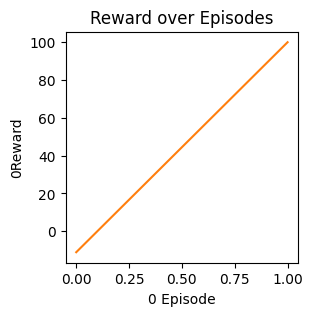

Policy Model saved to ./checkpoint_sm/0_dqn_model_loss_mean_0.000_reward_mean_44.472_policy_model.pth
Target Model saved to ./checkpoint_sm/0_dqn_model_loss_mean_0.000_reward_mean_44.472_target_model.pth
1  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:04,  9.74it/s, expected_reward=-15.3]


0 - epoch:1
Start state[93, 109, 91], State Pred [93, 109, 71, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {5: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-15.3052], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -15.3052


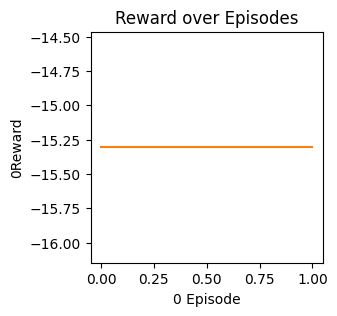

2  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 18.93it/s, expected_reward=-19.5]


0 - epoch:2
Start state[112, 81, 67], State Pred [92, 91, 67, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {1: 1, 2: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-20.7300], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -20.7300


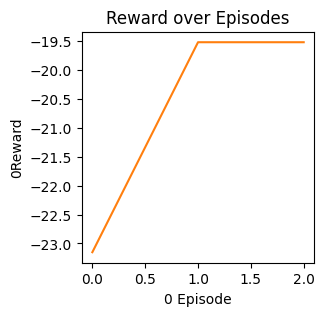

Policy Model saved to ./checkpoint_sm/2_dqn_model_loss_mean_0.000_reward_mean_-20.730_policy_model.pth
Target Model saved to ./checkpoint_sm/2_dqn_model_loss_mean_0.000_reward_mean_-20.730_target_model.pth
3  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 19.58it/s, expected_reward=-28.3]

0 - epoch:3
Start state[91, 78, 68], State Pred [91, 78, 88, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {4: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-28.2975], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -28.2975


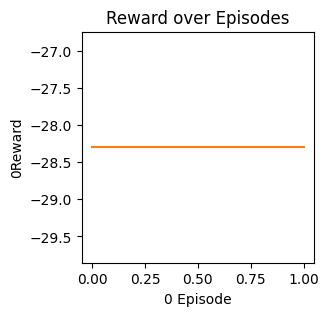

4  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 18.42it/s, expected_reward=-28.2]

0 - epoch:4
Start state[95, 98, 91], State Pred [95, 78, 91, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {3: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-28.1514], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -28.1514


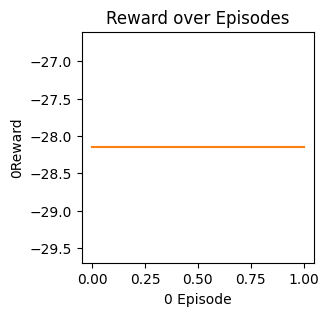

Policy Model saved to ./checkpoint_sm/4_dqn_model_loss_mean_0.000_reward_mean_-28.151_policy_model.pth
Target Model saved to ./checkpoint_sm/4_dqn_model_loss_mean_0.000_reward_mean_-28.151_target_model.pth
5  - epoch


Episodes:   8%|▊         | 4/50 [00:00<00:02, 19.56it/s, expected_reward=-24.5]


0 - epoch:5
Start state[91, 64, 83], State Pred [84, 94, 83, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 3, batch 0
defaultdict(<class 'int'>, {2: 2, 1: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-24.0217], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -24.0217


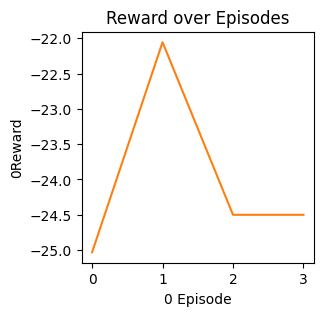

6  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 17.57it/s, expected_reward=-12.7]

0 - epoch:6
Start state[103, 93, 67], State Pred [123, 93, 67, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {0: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-12.7377], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -12.7377


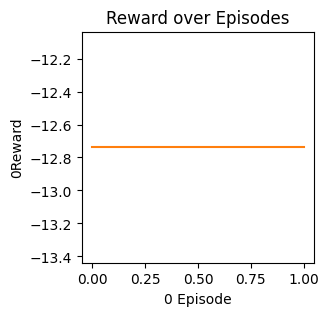

Policy Model saved to ./checkpoint_sm/6_dqn_model_loss_mean_0.000_reward_mean_-12.738_policy_model.pth
Target Model saved to ./checkpoint_sm/6_dqn_model_loss_mean_0.000_reward_mean_-12.738_target_model.pth
7  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 17.85it/s, expected_reward=-31.9]

0 - epoch:7
Start state[111, 81, 88], State Pred [111, 61, 88, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {3: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-31.8512], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -31.8512


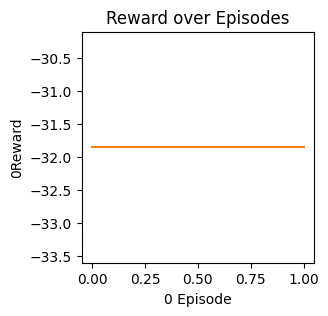

8  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 18.09it/s, expected_reward=-27.1]

0 - epoch:8
Start state[96, 76, 65], State Pred [96, 76, 85, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {4: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-27.0786], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -27.0786


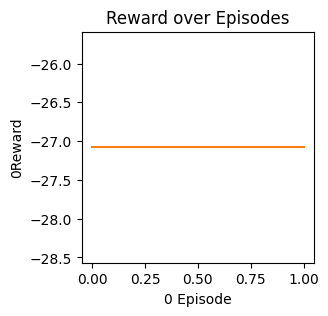

Policy Model saved to ./checkpoint_sm/8_dqn_model_loss_mean_0.000_reward_mean_-27.079_policy_model.pth
Target Model saved to ./checkpoint_sm/8_dqn_model_loss_mean_0.000_reward_mean_-27.079_target_model.pth
9  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 17.75it/s, expected_reward=-19.2]

0 - epoch:9
Start state[96, 79, 55], State Pred [116, 79, 55, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {0: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-19.2094], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -19.2094


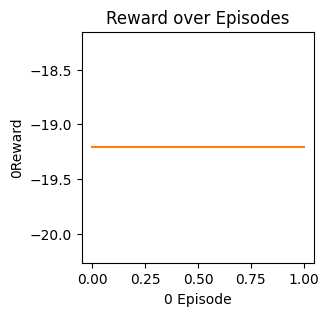

10  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 17.99it/s, expected_reward=-14.7]

0 - epoch:10
Start state[107, 74, 72], State Pred [107, 94, 72, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {2: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-14.7224], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -14.7224


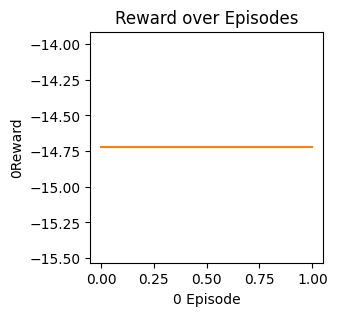

Policy Model saved to ./checkpoint_sm/10_dqn_model_loss_mean_0.000_reward_mean_-14.722_policy_model.pth
Target Model saved to ./checkpoint_sm/10_dqn_model_loss_mean_0.000_reward_mean_-14.722_target_model.pth
11  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 18.80it/s, expected_reward=-13.5]


0 - epoch:11
Start state[98, 132, 78], State Pred [108, 132, 78, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {0: 1, 1: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-13.0545], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -13.0545


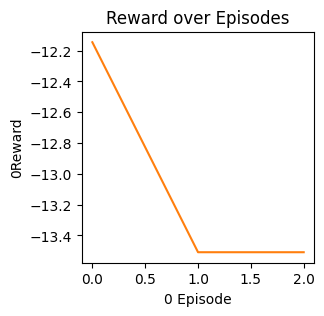

12  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 21.35it/s, expected_reward=-15.1]

0 - epoch:12


Episodes:   6%|▌         | 3/50 [00:00<00:02, 19.24it/s, expected_reward=-15.1]


Start state[114, 108, 55], State Pred [104, 108, 35, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {5: 1, 1: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-14.4594], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -14.4594


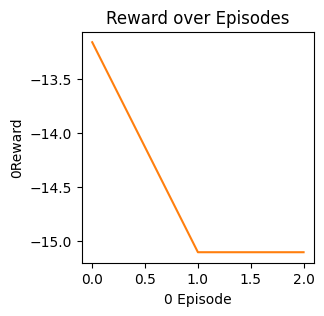

Policy Model saved to ./checkpoint_sm/12_dqn_model_loss_mean_0.000_reward_mean_-14.459_policy_model.pth
Target Model saved to ./checkpoint_sm/12_dqn_model_loss_mean_0.000_reward_mean_-14.459_target_model.pth
13  - epoch


Episodes:  10%|█         | 5/50 [00:00<00:02, 18.31it/s, expected_reward=-10.1]


0 - epoch:13
Start state[115, 118, 53], State Pred [115, 98, 64, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 4, batch 0
defaultdict(<class 'int'>, {3: 1, 4: 2, 5: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-10.3184], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -10.3184


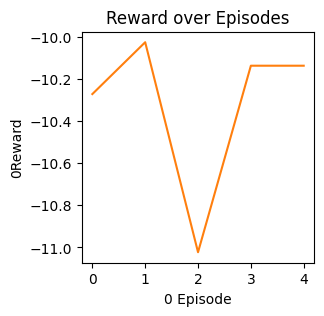

14  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 19.22it/s, expected_reward=-13]

0 - epoch:14
Start state[83, 99, 51], State Pred [103, 99, 51, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {0: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-13.0096], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -13.0096


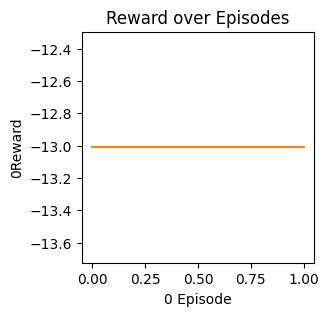

Policy Model saved to ./checkpoint_sm/14_dqn_model_loss_mean_0.000_reward_mean_-13.010_policy_model.pth
Target Model saved to ./checkpoint_sm/14_dqn_model_loss_mean_0.000_reward_mean_-13.010_target_model.pth
15  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 19.86it/s, expected_reward=-26.5]

0 - epoch:15
Start state[114, 73, 50], State Pred [114, 73, 30, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {5: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-26.5189], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -26.5189


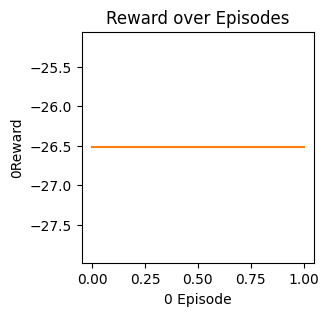

16  - epoch


Episodes:   2%|▏         | 1/50 [00:00<00:02, 20.95it/s, expected_reward=100]


0 - epoch:16
Start state[104, 101, 50], State Pred [124, 101, 50, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 0, batch 0
defaultdict(<class 'int'>, {0: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([100.], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL 100.0000


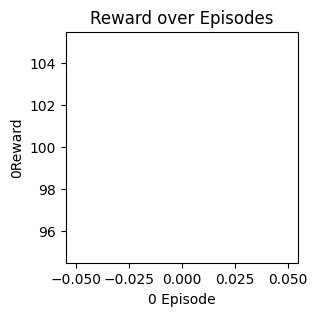

Policy Model saved to ./checkpoint_sm/16_dqn_model_loss_mean_0.000_reward_mean_100.000_policy_model.pth
Target Model saved to ./checkpoint_sm/16_dqn_model_loss_mean_0.000_reward_mean_100.000_target_model.pth
17  - epoch


Episodes: 100%|██████████| 50/50 [00:01<00:00, 25.05it/s, expected_reward=-24.8]


Start state[97, 85, 58], State Pred [97, 85, 29, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 49, batch 0
defaultdict(<class 'int'>, {5: 26, 4: 24})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([0.], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL 0.0000


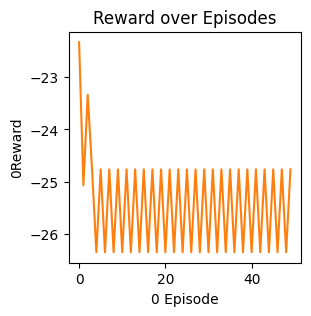

18  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:01, 23.62it/s, expected_reward=-24]

0 - epoch:18
Start state[106, 136, 77], State Pred [86, 136, 87, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {1: 1, 4: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-23.1407], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -23.1407


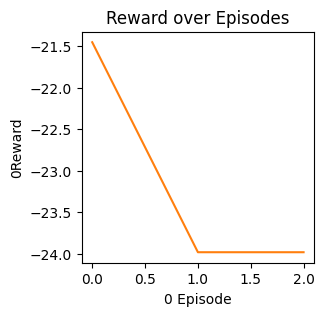

Policy Model saved to ./checkpoint_sm/18_dqn_model_loss_mean_0.000_reward_mean_-23.141_policy_model.pth
Target Model saved to ./checkpoint_sm/18_dqn_model_loss_mean_0.000_reward_mean_-23.141_target_model.pth
19  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:01, 24.19it/s, expected_reward=-21.9]

0 - epoch:19
Start state[99, 80, 85], State Pred [89, 100, 85, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {2: 1, 1: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-20.8782], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -20.8782


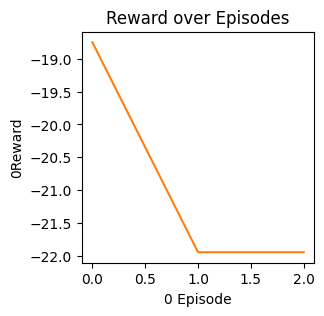

20  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 21.94it/s, expected_reward=-18.4]

0 - epoch:20
Start state[106, 63, 69], State Pred [106, 83, 59, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {2: 1, 5: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-18.6074], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -18.6074


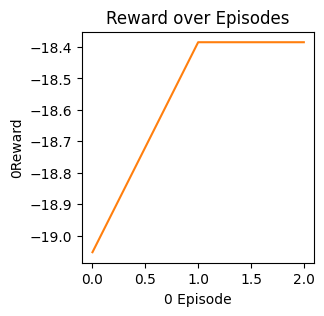

Policy Model saved to ./checkpoint_sm/20_dqn_model_loss_mean_0.000_reward_mean_-18.607_policy_model.pth
Target Model saved to ./checkpoint_sm/20_dqn_model_loss_mean_0.000_reward_mean_-18.607_target_model.pth
21  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 23.44it/s, expected_reward=-27.3]

0 - epoch:21
Start state[118, 133, 91], State Pred [118, 153, 100, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {2: 1, 4: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-26.2342], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -26.2342


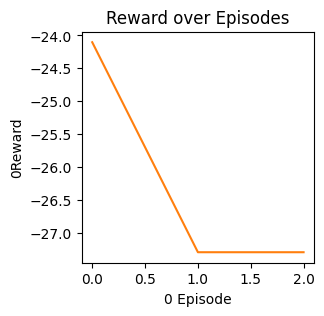

22  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 18.18it/s, expected_reward=-24.8]


0 - epoch:22
Start state[87, 101, 90], State Pred [97, 101, 100, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {4: 1, 0: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-25.7211], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -25.7211


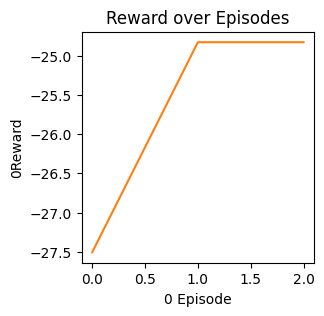

Policy Model saved to ./checkpoint_sm/22_dqn_model_loss_mean_0.000_reward_mean_-25.721_policy_model.pth
Target Model saved to ./checkpoint_sm/22_dqn_model_loss_mean_0.000_reward_mean_-25.721_target_model.pth
23  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 18.14it/s, expected_reward=-18.3]


0 - epoch:23
Start state[110, 127, 68], State Pred [100, 127, 88, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {4: 1, 1: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-17.5840], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -17.5840


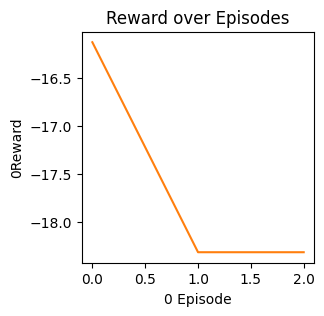

24  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 17.88it/s, expected_reward=-16.6]

0 - epoch:24
Start state[80, 92, 50], State Pred [100, 92, 50, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {0: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-16.6283], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -16.6283


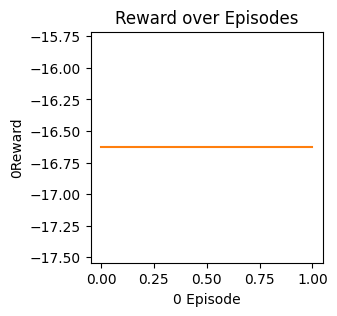

Policy Model saved to ./checkpoint_sm/24_dqn_model_loss_mean_0.000_reward_mean_-16.628_policy_model.pth
Target Model saved to ./checkpoint_sm/24_dqn_model_loss_mean_0.000_reward_mean_-16.628_target_model.pth
25  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 18.50it/s, expected_reward=-15.5]

0 - epoch:25
Start state[117, 104, 89], State Pred [117, 124, 89, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {2: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-15.4758], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -15.4758


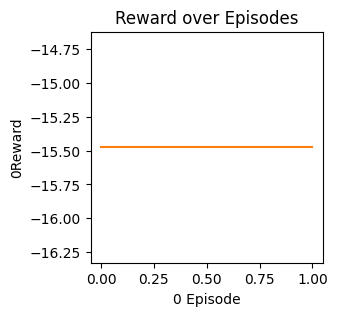

26  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 18.88it/s, expected_reward=-24.5]


0 - epoch:26
Start state[97, 125, 74], State Pred [77, 135, 74, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {1: 1, 2: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-24.0295], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -24.0295


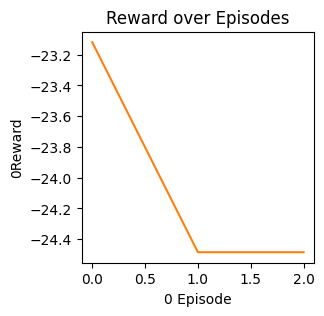

Policy Model saved to ./checkpoint_sm/26_dqn_model_loss_mean_0.000_reward_mean_-24.030_policy_model.pth
Target Model saved to ./checkpoint_sm/26_dqn_model_loss_mean_0.000_reward_mean_-24.030_target_model.pth
27  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 19.57it/s, expected_reward=-18.7]

0 - epoch:27
Start state[116, 85, 69], State Pred [116, 95, 89, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {4: 1, 2: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-19.8131], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -19.8131


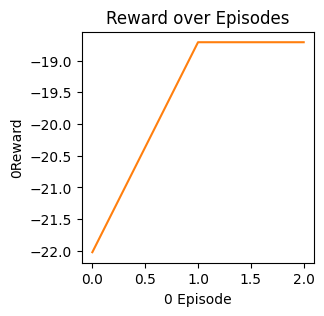

28  - epoch


Episodes:   2%|▏         | 1/50 [00:00<00:04, 11.94it/s, expected_reward=-19]

0 - epoch:28
Start state[94, 120, 81], State Pred [94, 100, 81, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0


Episodes:   4%|▍         | 2/50 [00:00<00:02, 20.33it/s, expected_reward=-19]


defaultdict(<class 'int'>, {3: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-19.0329], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -19.0329


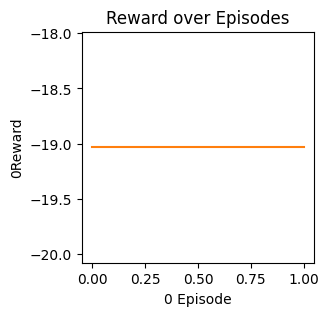

Policy Model saved to ./checkpoint_sm/28_dqn_model_loss_mean_0.000_reward_mean_-19.033_policy_model.pth
Target Model saved to ./checkpoint_sm/28_dqn_model_loss_mean_0.000_reward_mean_-19.033_target_model.pth
29  - epoch


Episodes:   2%|▏         | 1/50 [00:00<00:02, 19.29it/s, expected_reward=100]


0 - epoch:29
Start state[113, 123, 62], State Pred [133, 123, 62, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 0, batch 0
defaultdict(<class 'int'>, {0: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([100.], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL 100.0000


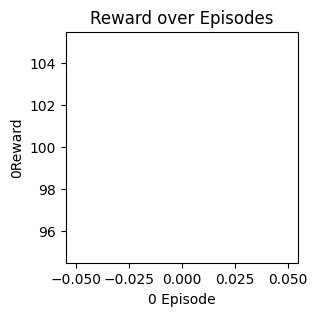

30  - epoch


Episodes:   8%|▊         | 4/50 [00:00<00:02, 20.26it/s, expected_reward=-17.8]


0 - epoch:30
Start state[80, 146, 71], State Pred [100, 146, 54, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 3, batch 0
defaultdict(<class 'int'>, {0: 1, 5: 2, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-17.9577], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -17.9577


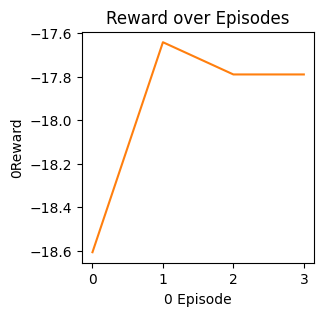

Policy Model saved to ./checkpoint_sm/30_dqn_model_loss_mean_0.000_reward_mean_-17.958_policy_model.pth
Target Model saved to ./checkpoint_sm/30_dqn_model_loss_mean_0.000_reward_mean_-17.958_target_model.pth
31  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 18.63it/s, expected_reward=-23.6]

0 - epoch:31
Start state[102, 115, 87], State Pred [82, 115, 87, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {1: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-23.6220], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -23.6220


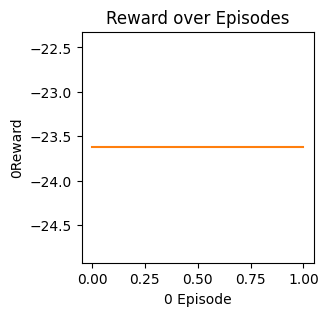

32  - epoch


Episodes:  28%|██▊       | 14/50 [00:00<00:01, 18.93it/s, expected_reward=-28.4]


0 - epoch:32
Start state[94, 76, 60], State Pred [99, 71, 33, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 13, batch 0
defaultdict(<class 'int'>, {5: 6, 0: 1, 4: 4, 3: 1, 1: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-25.5485], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -25.5485


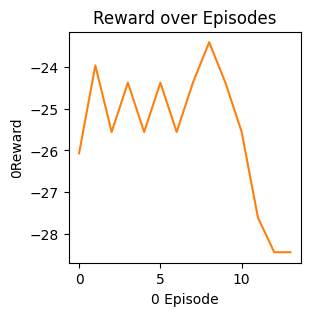

Policy Model saved to ./checkpoint_sm/32_dqn_model_loss_mean_0.000_reward_mean_-25.549_policy_model.pth
Target Model saved to ./checkpoint_sm/32_dqn_model_loss_mean_0.000_reward_mean_-25.549_target_model.pth
33  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 20.27it/s, expected_reward=-32.7]

0 - epoch:33
Start state[83, 133, 87], State Pred [83, 163, 87, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {2: 2, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-31.5672], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -31.5672


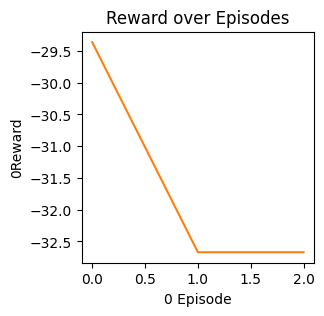

34  - epoch


Episodes:   8%|▊         | 4/50 [00:00<00:02, 22.96it/s, expected_reward=-26.6]


0 - epoch:34
Start state[87, 147, 74], State Pred [70, 127, 74, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 3, batch 0
defaultdict(<class 'int'>, {3: 1, 1: 2, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-23.8164], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -23.8164


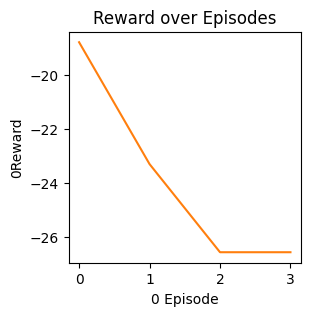

Policy Model saved to ./checkpoint_sm/34_dqn_model_loss_mean_0.000_reward_mean_-23.816_policy_model.pth
Target Model saved to ./checkpoint_sm/34_dqn_model_loss_mean_0.000_reward_mean_-23.816_target_model.pth
35  - epoch


Episodes:   2%|▏         | 1/50 [00:00<00:02, 23.09it/s, expected_reward=100]


0 - epoch:35
Start state[112, 146, 67], State Pred [112, 126, 67, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 0, batch 0
defaultdict(<class 'int'>, {3: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([100.], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL 100.0000


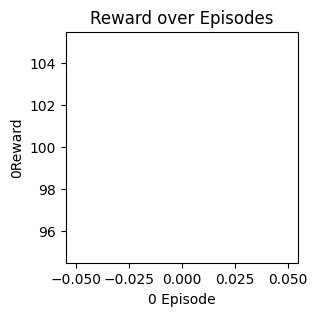

36  - epoch


Episodes:   8%|▊         | 4/50 [00:00<00:02, 18.91it/s, expected_reward=-26.7]


0 - epoch:36
Start state[115, 76, 87], State Pred [125, 76, 93, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 3, batch 0
defaultdict(<class 'int'>, {4: 1, 0: 1, 5: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-27.9239], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -27.9239


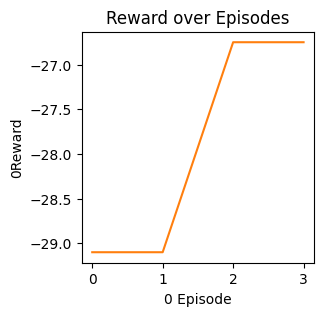

Policy Model saved to ./checkpoint_sm/36_dqn_model_loss_mean_0.000_reward_mean_-27.924_policy_model.pth
Target Model saved to ./checkpoint_sm/36_dqn_model_loss_mean_0.000_reward_mean_-27.924_target_model.pth
37  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 18.77it/s, expected_reward=-29.4]

0 - epoch:37
Start state[106, 70, 68], State Pred [86, 70, 68, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {1: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-29.3513], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -29.3513


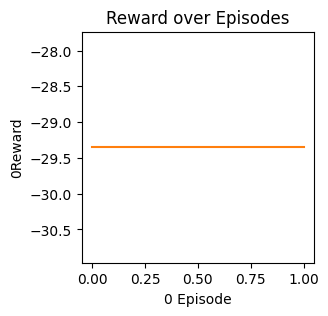

38  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 18.93it/s, expected_reward=-22.2]

0 - epoch:38
Start state[102, 77, 78], State Pred [122, 77, 78, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {0: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-22.1642], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -22.1642


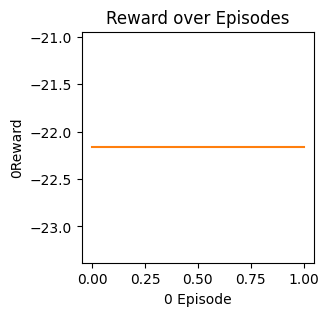

Policy Model saved to ./checkpoint_sm/38_dqn_model_loss_mean_0.000_reward_mean_-22.164_policy_model.pth
Target Model saved to ./checkpoint_sm/38_dqn_model_loss_mean_0.000_reward_mean_-22.164_target_model.pth
39  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 18.62it/s, expected_reward=-15.9]

0 - epoch:39
Start state[116, 115, 85], State Pred [116, 135, 85, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {2: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-15.9374], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -15.9374


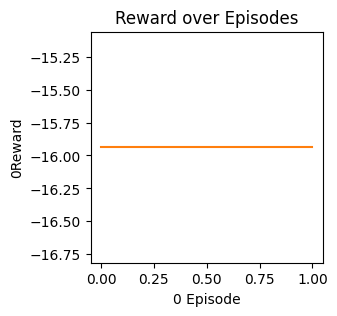

40  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 21.64it/s, expected_reward=-12.1]

0 - epoch:40


Episodes:   6%|▌         | 3/50 [00:00<00:02, 19.45it/s, expected_reward=-12.1]


Start state[92, 106, 89], State Pred [112, 106, 79, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {0: 1, 5: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-13.5521], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -13.5521


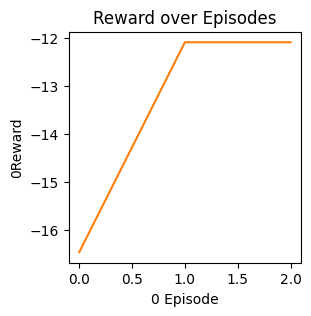

Policy Model saved to ./checkpoint_sm/40_dqn_model_loss_mean_0.000_reward_mean_-13.552_policy_model.pth
Target Model saved to ./checkpoint_sm/40_dqn_model_loss_mean_0.000_reward_mean_-13.552_target_model.pth
41  - epoch


Episodes:   8%|▊         | 4/50 [00:00<00:02, 18.66it/s, expected_reward=-35.3]


0 - epoch:41
Start state[81, 147, 67], State Pred [81, 173, 77, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 3, batch 0
defaultdict(<class 'int'>, {2: 2, 4: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-33.8729], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -33.8729


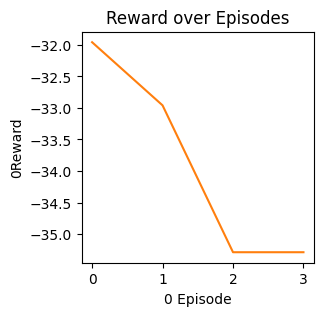

42  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 19.22it/s, expected_reward=-11.3]


0 - epoch:42
Start state[115, 103, 56], State Pred [125, 103, 76, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {4: 1, 0: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-11.2916], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -11.2916


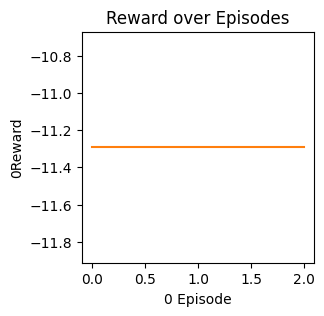

Policy Model saved to ./checkpoint_sm/42_dqn_model_loss_mean_0.000_reward_mean_-11.292_policy_model.pth
Target Model saved to ./checkpoint_sm/42_dqn_model_loss_mean_0.000_reward_mean_-11.292_target_model.pth
43  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 18.91it/s, expected_reward=-13.5]


0 - epoch:43
Start state[119, 101, 63], State Pred [99, 101, 53, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {1: 1, 5: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-13.4750], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -13.4750


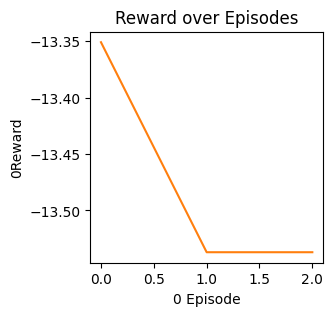

44  - epoch


Episodes:   2%|▏         | 1/50 [00:00<00:02, 18.61it/s, expected_reward=100]


0 - epoch:44
Start state[119, 99, 85], State Pred [119, 99, 65, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 0, batch 0
defaultdict(<class 'int'>, {5: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([100.], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL 100.0000


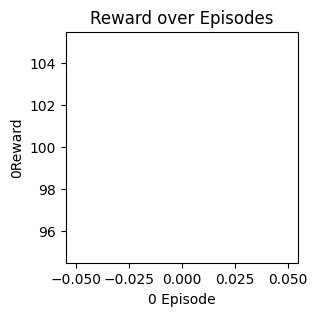

Policy Model saved to ./checkpoint_sm/44_dqn_model_loss_mean_0.000_reward_mean_100.000_policy_model.pth
Target Model saved to ./checkpoint_sm/44_dqn_model_loss_mean_0.000_reward_mean_100.000_target_model.pth
45  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 18.78it/s, expected_reward=-14.7]

0 - epoch:45
Start state[96, 101, 73], State Pred [96, 101, 53, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {5: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-14.7309], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -14.7309


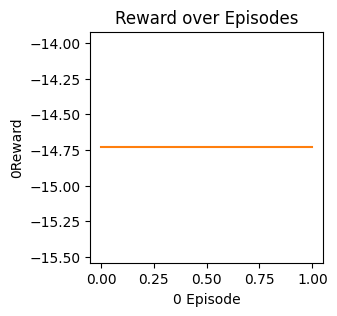

46  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 19.21it/s, expected_reward=-15.2]

0 - epoch:46
Start state[100, 123, 77], State Pred [100, 103, 77, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {3: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-15.1658], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -15.1658


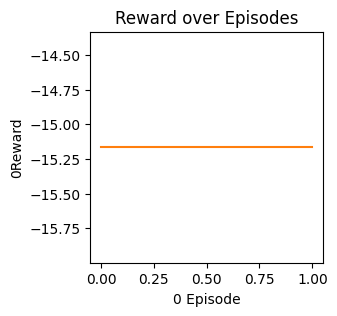

Policy Model saved to ./checkpoint_sm/46_dqn_model_loss_mean_0.000_reward_mean_-15.166_policy_model.pth
Target Model saved to ./checkpoint_sm/46_dqn_model_loss_mean_0.000_reward_mean_-15.166_target_model.pth
47  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 18.85it/s, expected_reward=-27.7]

0 - epoch:47
Start state[117, 80, 91], State Pred [117, 80, 100, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {4: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-27.6541], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -27.6541


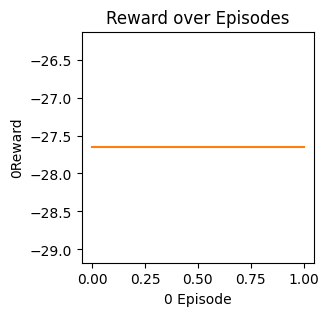

48  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 18.83it/s, expected_reward=-22.4]

0 - epoch:48
Start state[91, 77, 77], State Pred [111, 77, 77, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {0: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-22.3886], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -22.3886


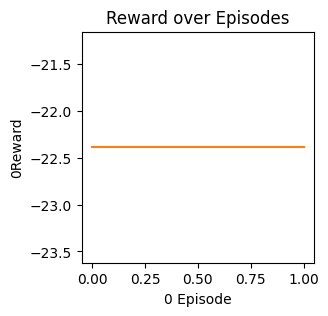

Policy Model saved to ./checkpoint_sm/48_dqn_model_loss_mean_0.000_reward_mean_-22.389_policy_model.pth
Target Model saved to ./checkpoint_sm/48_dqn_model_loss_mean_0.000_reward_mean_-22.389_target_model.pth
49  - epoch


Episodes:  10%|█         | 5/50 [00:00<00:02, 19.51it/s, expected_reward=-31.1]


0 - epoch:49
Start state[88, 68, 72], State Pred [88, 68, 80, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 4, batch 0
defaultdict(<class 'int'>, {4: 2, 5: 2, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-31.5093], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -31.5093


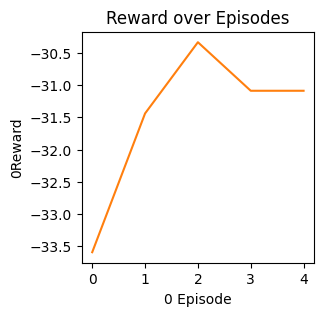

50  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 19.52it/s, expected_reward=-27.6]

0 - epoch:50
Start state[118, 86, 80], State Pred [118, 66, 80, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {3: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-27.5953], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -27.5953


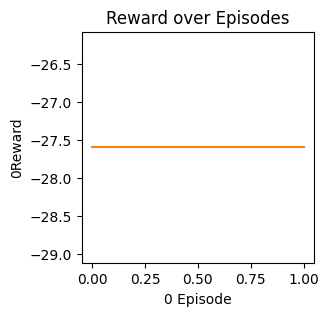

Policy Model saved to ./checkpoint_sm/50_dqn_model_loss_mean_0.000_reward_mean_-27.595_policy_model.pth
Target Model saved to ./checkpoint_sm/50_dqn_model_loss_mean_0.000_reward_mean_-27.595_target_model.pth
51  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 19.12it/s, expected_reward=100]

0 - epoch:51
Start state[99, 106, 70], State Pred [109, 106, 50, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {5: 1, 0: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([43.6606], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL 43.6606


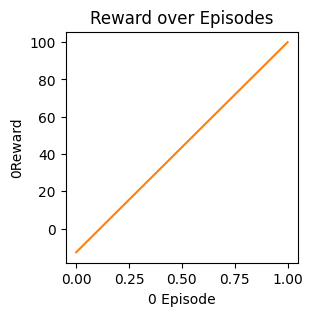

52  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 18.09it/s, expected_reward=-27.4]

0 - epoch:52
Start state[106, 63, 66], State Pred [126, 63, 66, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {0: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-27.3907], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -27.3907


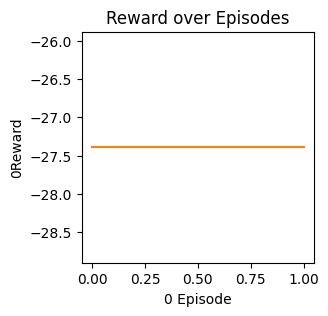

Policy Model saved to ./checkpoint_sm/52_dqn_model_loss_mean_0.000_reward_mean_-27.391_policy_model.pth
Target Model saved to ./checkpoint_sm/52_dqn_model_loss_mean_0.000_reward_mean_-27.391_target_model.pth
53  - epoch


Episodes:   6%|▌         | 3/50 [00:00<00:02, 19.14it/s, expected_reward=-24]


0 - epoch:53
Start state[94, 138, 67], State Pred [74, 128, 67, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {1: 1, 3: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-24.5222], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -24.5222


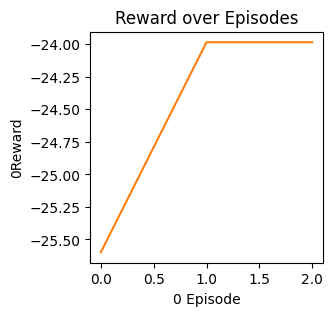

54  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:02, 19.03it/s, expected_reward=-27.7]

0 - epoch:54
Start state[85, 124, 57], State Pred [65, 124, 57, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {1: 1, 6: 1})  - action_set
tensor([0.], dtype=torch.float64)  - loss_batch
tensor([-27.7399], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 0.0000 	Expected_Reward_RL -27.7399


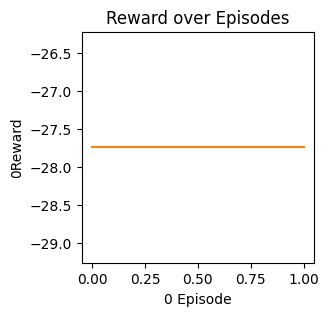

Policy Model saved to ./checkpoint_sm/54_dqn_model_loss_mean_0.000_reward_mean_-27.740_policy_model.pth
Target Model saved to ./checkpoint_sm/54_dqn_model_loss_mean_0.000_reward_mean_-27.740_target_model.pth
55  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:20,  2.33it/s, expected_reward=100]

tensor(15.8961, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:55
Start state[100, 103, 75], State Pred [110, 103, 55, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {5: 1, 0: 1})  - action_set
tensor([7.9481], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([43.8153], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 7.9481 	Expected_Reward_RL 43.8153


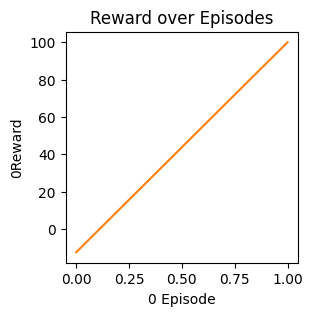

56  - epoch


Episodes:   4%|▍         | 2/50 [00:01<00:35,  1.36it/s, expected_reward=100]

tensor(20.7167, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:56
Start state[115, 108, 58], State Pred [115, 118, 78, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {4: 1, 2: 1})  - action_set
tensor([10.3583], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([44.5975], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 10.3583 	Expected_Reward_RL 44.5975


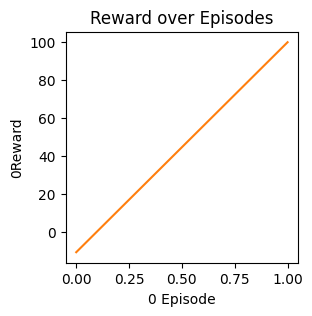

Policy Model saved to ./checkpoint_sm/56_dqn_model_loss_mean_10.358_reward_mean_44.597_policy_model.pth
Target Model saved to ./checkpoint_sm/56_dqn_model_loss_mean_10.358_reward_mean_44.597_target_model.pth
57  - epoch


Episodes:   2%|▏         | 1/50 [00:00<00:35,  1.36it/s, expected_reward=100]

tensor(19.9767, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:57
Start state[119, 118, 65], State Pred [119, 98, 65, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 0, batch 0
defaultdict(<class 'int'>, {3: 1})  - action_set
tensor([19.9767], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([100.], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 19.9767 	Expected_Reward_RL 100.0000


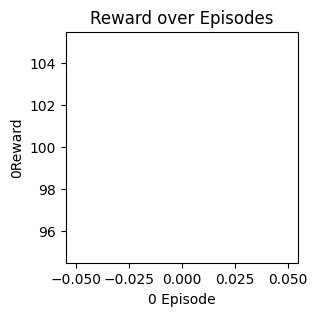

58  - epoch


Episodes:   6%|▌         | 3/50 [00:02<00:34,  1.35it/s, expected_reward=-28]

tensor(22.8222, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:58
Start state[112, 143, 90], State Pred [92, 143, 100, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {1: 1, 4: 1, 6: 1})  - action_set
tensor([7.6074], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([-26.8822], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 7.6074 	Expected_Reward_RL -26.8822


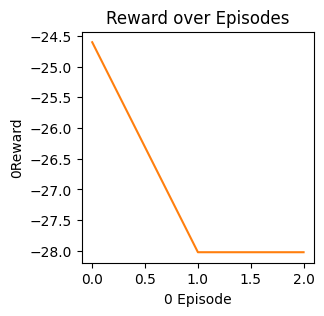

Policy Model saved to ./checkpoint_sm/58_dqn_model_loss_mean_7.607_reward_mean_-26.882_policy_model.pth
Target Model saved to ./checkpoint_sm/58_dqn_model_loss_mean_7.607_reward_mean_-26.882_target_model.pth
59  - epoch


Episodes:   4%|▍         | 2/50 [00:01<00:34,  1.37it/s, expected_reward=-25.9]

tensor(20.3800, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:59
Start state[104, 146, 53], State Pred [104, 166, 53, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {2: 1, 6: 1})  - action_set
tensor([10.1900], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([-25.9471], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 10.1900 	Expected_Reward_RL -25.9471


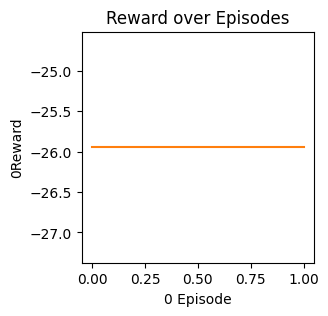

60  - epoch


Episodes:   6%|▌         | 3/50 [00:02<00:34,  1.38it/s, expected_reward=-24.5]

tensor(20.2582, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:60
Start state[93, 106, 67], State Pred [83, 86, 67, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {3: 1, 1: 1, 6: 1})  - action_set
tensor([6.7527], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([-23.2896], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 6.7527 	Expected_Reward_RL -23.2896


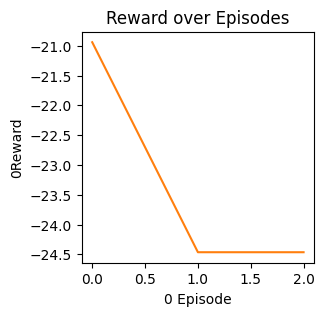

Policy Model saved to ./checkpoint_sm/60_dqn_model_loss_mean_6.753_reward_mean_-23.290_policy_model.pth
Target Model saved to ./checkpoint_sm/60_dqn_model_loss_mean_6.753_reward_mean_-23.290_target_model.pth
61  - epoch


Episodes:   6%|▌         | 3/50 [00:02<00:34,  1.37it/s, expected_reward=-16.3]

tensor(21.9314, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:61
Start state[115, 85, 93], State Pred [115, 85, 63, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {5: 2, 6: 1})  - action_set
tensor([7.3105], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([-16.7589], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 7.3105 	Expected_Reward_RL -16.7589


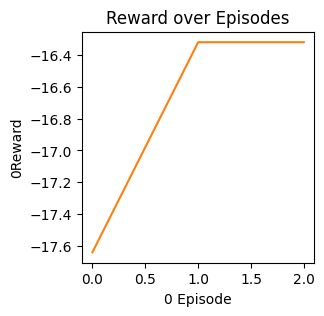

62  - epoch


Episodes:   4%|▍         | 2/50 [00:01<00:34,  1.37it/s, expected_reward=-17.1]

tensor(17.5047, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:62
Start state[90, 82, 52], State Pred [90, 102, 52, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {2: 1, 6: 1})  - action_set
tensor([8.7524], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([-17.1318], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 8.7524 	Expected_Reward_RL -17.1318


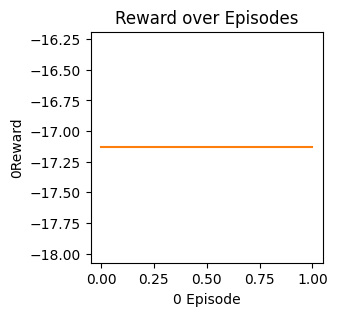

Policy Model saved to ./checkpoint_sm/62_dqn_model_loss_mean_8.752_reward_mean_-17.132_policy_model.pth
Target Model saved to ./checkpoint_sm/62_dqn_model_loss_mean_8.752_reward_mean_-17.132_target_model.pth
63  - epoch


Episodes:   4%|▍         | 2/50 [00:01<00:35,  1.36it/s, expected_reward=-40.1]

tensor(26.8505, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:63
Start state[80, 64, 62], State Pred [60, 64, 62, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {1: 1, 6: 1})  - action_set
tensor([13.4252], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([-40.0562], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 13.4252 	Expected_Reward_RL -40.0562


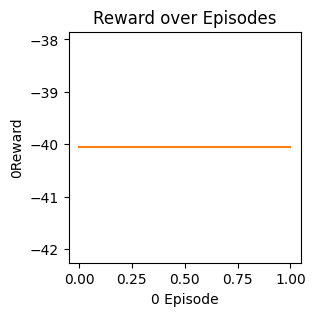

64  - epoch


Episodes:   2%|▏         | 1/50 [00:00<00:36,  1.35it/s, expected_reward=100]

tensor(22.8998, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:64
Start state[104, 117, 51], State Pred [124, 117, 51, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 0, batch 0
defaultdict(<class 'int'>, {0: 1})  - action_set
tensor([22.8998], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([100.], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 22.8998 	Expected_Reward_RL 100.0000


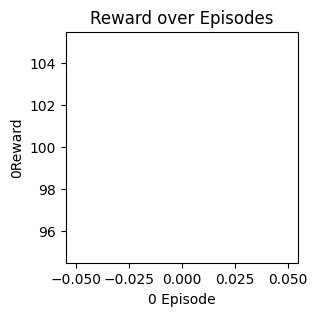

Policy Model saved to ./checkpoint_sm/64_dqn_model_loss_mean_22.900_reward_mean_100.000_policy_model.pth
Target Model saved to ./checkpoint_sm/64_dqn_model_loss_mean_22.900_reward_mean_100.000_target_model.pth
65  - epoch


Episodes:   4%|▍         | 2/50 [00:01<00:35,  1.37it/s, expected_reward=-29.5]

tensor(24.2680, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:65
Start state[85, 70, 85], State Pred [85, 70, 65, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {5: 1, 6: 1})  - action_set
tensor([12.1340], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([-29.4534], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 12.1340 	Expected_Reward_RL -29.4534


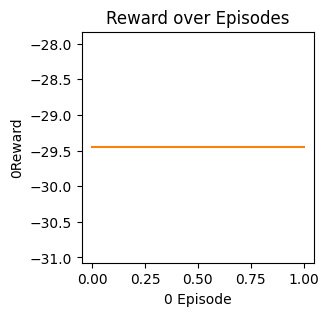

66  - epoch


Episodes:   6%|▌         | 3/50 [00:02<00:34,  1.37it/s, expected_reward=-22.3]

tensor(22.2542, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:66
Start state[115, 73, 54], State Pred [115, 73, 64, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {4: 1, 5: 1, 6: 1})  - action_set
tensor([7.4181], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([-22.6473], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 7.4181 	Expected_Reward_RL -22.6473


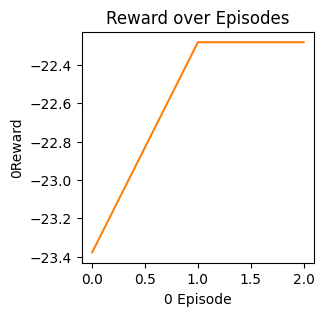

Policy Model saved to ./checkpoint_sm/66_dqn_model_loss_mean_7.418_reward_mean_-22.647_policy_model.pth
Target Model saved to ./checkpoint_sm/66_dqn_model_loss_mean_7.418_reward_mean_-22.647_target_model.pth
67  - epoch


Episodes:   4%|▍         | 2/50 [00:01<00:35,  1.36it/s, expected_reward=-41]

tensor(18.6077, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:67
Start state[84, 64, 69], State Pred [84, 44, 69, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {3: 1, 6: 1})  - action_set
tensor([9.3038], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([-41.0030], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 9.3038 	Expected_Reward_RL -41.0030


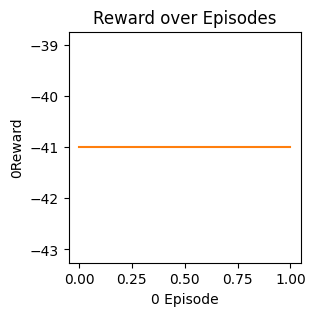

68  - epoch


Episodes:   4%|▍         | 2/50 [00:01<00:35,  1.36it/s, expected_reward=-27.7]

tensor(21.5390, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:68
Start state[97, 131, 91], State Pred [77, 131, 91, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {1: 1, 6: 1})  - action_set
tensor([10.7695], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([-27.6993], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 10.7695 	Expected_Reward_RL -27.6993


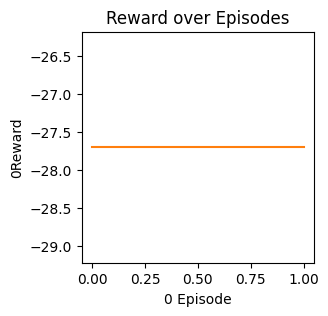

Policy Model saved to ./checkpoint_sm/68_dqn_model_loss_mean_10.769_reward_mean_-27.699_policy_model.pth
Target Model saved to ./checkpoint_sm/68_dqn_model_loss_mean_10.769_reward_mean_-27.699_target_model.pth
69  - epoch


Episodes:   6%|▌         | 3/50 [00:02<00:34,  1.37it/s, expected_reward=-34.2]

tensor(26.1138, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:69
Start state[111, 63, 74], State Pred [111, 63, 100, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 2, batch 0
defaultdict(<class 'int'>, {4: 2, 6: 1})  - action_set
tensor([8.7046], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([-33.6281], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 8.7046 	Expected_Reward_RL -33.6281


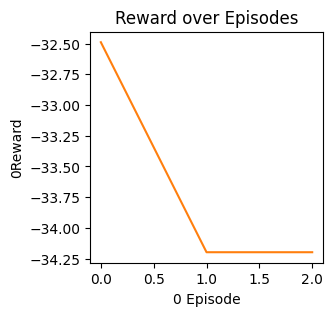

70  - epoch


Episodes:   4%|▍         | 2/50 [00:01<00:35,  1.37it/s, expected_reward=-27.9]

tensor(27.2187, device='cuda:1', grad_fn=<SmoothL1LossBackward0>) - epoch:70
Start state[84, 95, 52], State Pred [84, 75, 52, 50, 60, 50] , ground truth [122 122  58  48  55  51], episodes 1, batch 0
defaultdict(<class 'int'>, {3: 1, 6: 1})  - action_set
tensor([13.6093], dtype=torch.float64, grad_fn=<CopySlices>)  - loss_batch
tensor([-27.8792], dtype=torch.float64)  - expected_reward_batch
Loss_Rl 13.6093 	Expected_Reward_RL -27.8792


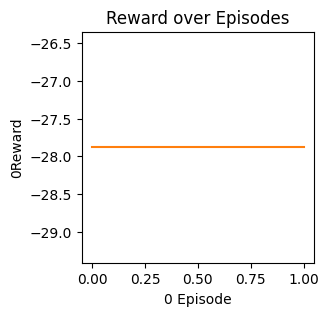

Policy Model saved to ./checkpoint_sm/70_dqn_model_loss_mean_13.609_reward_mean_-27.879_policy_model.pth
Target Model saved to ./checkpoint_sm/70_dqn_model_loss_mean_13.609_reward_mean_-27.879_target_model.pth
71  - epoch


Episodes:   4%|▍         | 2/50 [00:00<00:18,  2.65it/s, expected_reward=-16.4]

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d,MaxUnpool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD, AdamW
from skimage import util
from torchvision import transforms, models
from torch import optim
import torchvision
import math
from tqdm import tqdm
import numpy as np
import os
from collections import defaultdict


def training_phase(dqn_model, dataloader):
    training_acc = []
    training_loss = []
    scaler = torch.cuda.amp.GradScaler()
    with torch.cuda.amp.autocast():
        for epoch in range(epoch_length + 1):
            print(epoch, " - epoch")
            train_loss = 0.0
            train_acc = 0.0
            total = 0.0
            for data in dataloader:
                # images, box_gds, labels = data
                images, box_gds = data
                batches, height, width, depth = images.shape
                dqn_mask = []
                loss_batch = torch.tensor(np.zeros(batches))
                expected_reward_batch = torch.tensor(np.zeros(batches))
                dqn_mask = torch.tensor(np.ones((batches,1,50,height,width)))
                # batch 만큼 processor를 만듦.
                loss_list, reward_list = [[] for _ in range(len(data))], [[] for _ in range(len(data))]
                for batch in range(batches):
                    # print(batch, " - batch")
                    # TODO: x, y, z가 80~120, 60~150, 50~95로 시작하는데, 이거는 따로 우리의 데이터에 맞게 수정해야함.
                    x_start = np.random.randint(80,120)
                    y_start = np.random.randint(60,200-50)
                    z_start = np.random.randint(50,145-50)
                    w, h, d = 50, 60, 50
                    start_state = [x_start, y_start, z_start, w, h, d]
                    game = "continue"
                    env = images[batch]
                    # 3D Labeling으로 x, y, z, w, h ,d가 필요함.
            
                    x_gd, y_gd, z_gd = box_gds[batch][0], box_gds[batch][1], box_gds[batch][2]
                    w_gd, h_gd, d_gd = box_gds[batch][3], box_gds[batch][4], box_gds[batch][5]
                    state_gd = [x_gd, y_gd, z_gd, w_gd, h_gd, d_gd]
                    start_eps = 1
                    end_eps = 0.004
                    # start_step = 20
                    # end_step = 5
                    # print(start_state, state_gd, " - start_state, state_gd")
                    prev_state = start_state.copy()
                    loss = 0
                    expected_rewards = 0
                    action_set = defaultdict(int)
                    # TODO : tqdm으로 desc 수정.
                    with tqdm(total=train_episode_length, desc = "Episodes") as pbar:
                        for episodes in range(train_episode_length):
                            eps = max(0,(start_eps/int(1 + episodes)   - end_eps))
                            # 예상되는 step의 값은 20 
                            step = max(end_step, start_step/int(1 + episodes) )

                            # TODO: crop_reshape 함수가 하는 역할을 이해하고 우리의 데이터에 맞게 수정해야함.
                            # crop_reshpe는 3D로 바꿔주는 함수, crop_reshape(env, x, y, z, w, h, d) -> env[x:x+w, y:y+h, z:z+d]
                            # 즉, 원래 목적은 shape이 맞지 않은 3D image를 interpolation을 통해서 3D로 확장했음.
                            # 우리의 데이터는 그럴 필요가 없기 때문에, 바로 넘겨줘도 될 듯 함.
                            # 다만 prev_state가 정확히 어떤 의미인지 잘 모르겟음
                            # prev_state : [x, y, z, w, h, d]
                            prev_patch = crop_reshape(env, prev_state[0],prev_state[1],prev_state[2],prev_state[3],prev_state[4],prev_state[5]).to( device)
                            action = dqn_model.select_action(prev_patch, game, eps)
                            # print(action, "- action")
                            if action != 6:
                                nxt_state = dqn_model.next_state(prev_state, action, step)
                                nxt_patch = crop_reshape(env, nxt_state[0],nxt_state[1],nxt_state[2],nxt_state[3],nxt_state[4],nxt_state[5])
                                # print(nxt_state, " - nxt_state")
                                # print(np.shape(nxt_patch), " - nxt_patch.shape")
                                game, expected_reward = dqn_model.compute_reward(nxt_state, prev_state, state_gd, 10)
                            else:
                                game = "END"
                                nxt_state = prev_state.copy()
                                nxt_patch = crop_reshape(env, nxt_state[0],nxt_state[1],nxt_state[2],nxt_state[3],nxt_state[4],nxt_state[5])
                                # print(nxt_state, " - nxt_state")
                                # print(np.shape(nxt_patch), " - nxt_patch.shape")
                                _, expected_reward = dqn_model.compute_reward(nxt_state, prev_state, state_gd, 10)
                            #print(np.asarray(action))
                            if debug:
                                print(expected_reward, "- expected_reward")
                            
                            action_set[np.max(action).item()] += 1
                            
                            dqn_model.store_transition(prev_patch, np.asarray(int(action)), expected_reward, nxt_patch)
                            pbar.set_postfix({'expected_reward': expected_reward})
                            pbar.update(1)
                            if dqn_model.memory.memory_counter >= model_update_count:
                                # print(dqn_model.memory.memory_counter, "- dqn_model.memory.memory_counter")
                                loss = dqn_model.optimize(model_update_count)
                                # memory가 다 차면 무조건 optimize를 함.
                                # print(loss, "- loss")


                            prev_state = nxt_state.copy()
                            prev_patch = crop_reshape(env, nxt_state[0],nxt_state[1],nxt_state[2],nxt_state[3],nxt_state[4],nxt_state[5])
                            expected_rewards += expected_reward
                            #print("Episodes : ", episodes)
                            reward_list[batch].append(expected_reward)
                            if game == "END" or episodes == train_episode_length:
                                print(loss, f"- epoch:{epoch}")
                                dqn_mask[batch] = nxt_patch.view(1, nxt_patch.shape[-3], nxt_patch.shape[-2],nxt_patch.shape[-1])
                                loss_batch[batch] = (loss/int(1 + episodes))
                                expected_reward_batch[batch] = (expected_rewards/int(1 + episodes))
                                break
                                
                        print("Start state{:}, State Pred {:} , ground truth {:}, episodes {:}, batch {:}".format(start_state[:3], nxt_state , np.array(state_gd), episodes, batch))
                    try:
                        loss_per_batch = loss_batch.numpy().detach()
                    except:
                        loss_per_batch = loss_batch
                    print(action_set, " - action_set")
                    print(loss_batch, " - loss_batch")
                    print(expected_reward_batch, " - expected_reward_batch")
                    print("Loss_Rl {:.4f} \tExpected_Reward_RL {:.4f}".format (loss_per_batch.mean(), expected_reward_batch.mean()))
                # viz loss and reward
                plt.figure(figsize=(3, 3))
                plt.plot(loss_list[batch])
                plt.plot(reward_list[batch])
                plt.xlabel(f'{batch} Episode')
                plt.ylabel(f'{batch}Reward')
                plt.title('Reward over Episodes')
                plt.show()
            if epoch % 2 == 0:
                
                checkpoint_dir = './checkpoint_sm'

                # 평균 손실 및 평균 보상 값을 사용하여 기본 파일명 생성
                base_filename = f'dqn_model_loss_mean_{loss_per_batch.mean():.3f}_reward_mean_{expected_reward_batch.mean():.3f}'

                # 각각의 모델 파일명 생성
                policy_model_filename = os.path.join(checkpoint_dir, f'{epoch}_{base_filename}_policy_model.pth')
                target_model_filename = os.path.join(checkpoint_dir, f'{epoch}_{base_filename}_target_model.pth')

                # 폴더가 존재하지 않으면 생성
                if not os.path.exists(checkpoint_dir):
                    os.makedirs(checkpoint_dir)

                # 모델 저장
                torch.save(dqn_model.policy_model.state_dict(), policy_model_filename)
                torch.save(dqn_model.target_model.state_dict(), target_model_filename)
                print(f"Policy Model saved to {policy_model_filename}")
                print(f"Target Model saved to {target_model_filename}")
            # print(loss_per_batch.shape)
    return training_acc, training_loss

t_phase1, l_phase1 = training_phase(my_dqn,  dataloader_train)

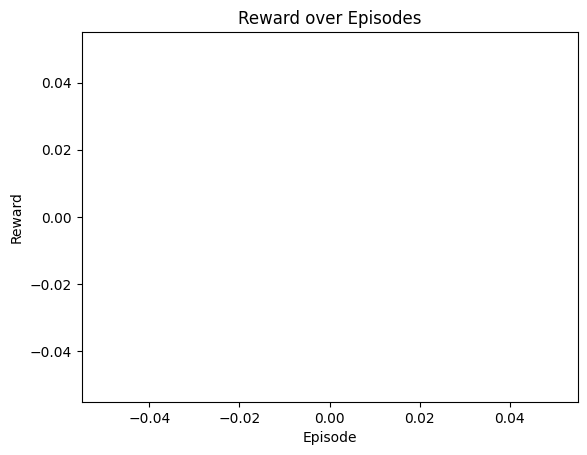

In [ ]:
import matplotlib.pyplot as plt

# Plotting the reward_list
plt.plot(reward_list)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward over Episodes')
plt.show()

In [ ]:
# TODO: Inference 코드 짜서 저장된 checkpoint로 실험해보기
# TODO: Visuzlization(BBOX + GIF느낌)

# Testing

In [ ]:
for data in dataloader_unseen:
    # images, box_gds, labels = data
    images, box_gds = data
    print(images.shape, " - images.shape")
    print(box_gds, " - box_gds")
print(len(dataloader_unseen))

torch.Size([1, 240, 240, 155])  - images.shape
tensor([[122, 122,  58,  48,  55,  51]])  - box_gds
1


In [ ]:
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# import torch.nn.functional as F
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.autograd import Variable
# from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d,MaxUnpool2d, Module, Softmax, BatchNorm2d, Dropout
# from torch.optim import Adam, SGD
# from skimage import util
# from torchvision import transforms, models
# from torch import optim
# from sklearn.metrics import confusion_matrix
# import cv2
# import torchvision
# import math
# from sklearn.utils import shuffle
# from tqdm import tqdm

# test_reward_list = []
# test_episode_length = 100
# test_epoch_length = 10

# def testing_phase(dqn_model, dataloader):
#     testing_acc = []
#     testing_loss = []
#     pred_test = []
#     pred_true = []
#     final_box = []
#     test_loss = 0.0
#     test_acc = 0.0
#     total = 0.0
#     for data in dataloader:
#         images, box_gds = data
#         batches, height, width, depth = images.shape
#         loss_batch = torch.tensor(np.ones(batches))
#         reward_batch = torch.tensor(np.ones(batches))
#         dqn_mask = torch.tensor(np.ones((batches,1,50,height,width)))
        
#         for batch in range(batches):
#             x_start = np.random.randint(80,120)
#             y_start = np.random.randint(60,200-50)
#             z_start = np.random.randint(50,145-50)
#             w, h, d = 50, 60, 50
#             start_state = [x_start, y_start, z_start, w, h, d]
#             if debug:
#                 print(batch, "batch : ", start_state, "start_state")
#             game = "continue"
#             env = images[batch]
#             x_gd, y_gd, z_gd = box_gds[batch][0], box_gds[batch][1], box_gds[batch][2]
#             w_gd, h_gd, d_gd = box_gds[batch][3], box_gds[batch][4], box_gds[batch][5]
#             state_gd = [x_gd, y_gd, z_gd, w_gd, h_gd, d_gd]
#             start_eps = 1
#             end_eps = 0.004
#             start_step = 10
#             end_step = 1
#             prev_state = start_state.copy()
#             loss = 0
#             rewards = 0
#             for episodes in range(episode_length):
#                 eps = max(0,(start_eps/int(1 + episodes)   - end_eps))
#                 step = max(end_step, start_step/int(1 + episodes) )
                
#                 prev_patch = crop_reshape(env, prev_state[0],prev_state[1],prev_state[2],prev_state[3],prev_state[4],prev_state[5]).to( device)
#                 action = dqn_model.select_action_test(prev_patch)
#                 print(action, " - test_action")
#                 if action != 6:
#                     nxt_state = dqn_model.next_state(prev_state, action, step)
#                     # print(nxt_state)
#                     nxt_patch = crop_reshape(env, nxt_state[0],nxt_state[1],nxt_state[2],nxt_state[3],nxt_state[4],nxt_state[5])
#                     game, reward = dqn_model.compute_reward(nxt_state, prev_state, state_gd, 10)
#                 else:
#                     action = np.
#                     game = "END"
#                     nxt_state = prev_state.copy()
#                     nxt_patch = crop_reshape(env, nxt_state[0],nxt_state[1],nxt_state[2],nxt_state[3],nxt_state[4],nxt_state[5])
#                     _, reward = dqn_model.compute_reward(nxt_state,prev_state, state_gd, 10)
#                     #print(np.asarray(action))
#                 prev_state = nxt_state.copy()
#                 prev_patch = crop_reshape(env, nxt_state[0],nxt_state[1],nxt_state[2],nxt_state[3],nxt_state[4],nxt_state[5])
#                 rewards += reward
#                 test_reward_list.append(reward)
#                 #print("Episodes : ", episodes)
#                 if game == "END" or episodes == 500:
#                     dqn_mask[batch] = nxt_patch.view(1, nxt_patch.shape[-3], nxt_patch.shape[-2],nxt_patch.shape[-1])
#                     loss_batch[batch] = (loss/int(1 + episodes))
#                     reward_batch[batch] = (rewards/int(1 + episodes))
#                     # break
#                     if debug:
#                         try:
#                             loss_per_batch = loss_batch.numpy().detach()
#                         except:
#                             loss_per_batch = loss_batch
#                         print("Loss_Rl {:.4f} \tReward_RL {:.4f}".format (loss_per_batch.mean(), reward_batch.mean()))
                    
#             print("State Pred {:} , ground truth {:}, episodes {:}, batch {:}".format(nxt_state , np.array(state_gd), episodes, batch))
#         try:
#             loss_per_batch = loss_batch.numpy().detach()
#         except:
#             loss_per_batch = loss_batch

#         print(loss_per_batch.shape)
#         print("Loss_Rl {:.4f} \tReward_RL {:.4f}".format (loss_per_batch.mean(), reward_batch.mean()))
#         # out_pred = classifier_model(dqn_mask.float(), images.view(batches, 1, depth, height, width).float())
#         # loss = criterion(out_pred, labels.type(torch.LongTensor))#.view(-1,1) float()
#         # test_loss += loss.item()
#         # total += labels.size(0)
#         # test_acc +=  binary_acc(out_pred, labels)
#         # pred_test.append(int(out_pred.detach()))
#         # pred_true.append(int(labels))
#         # final_box.append([nxt_state, np.array(state_gd)])
#     # test_loss = test_loss/len(dataloader)
#     # testing_loss.append(test_loss)
#     # test_acc = test_acc/total #100 *
#     # testing_acc.append(test_acc)
#     # print('Test Loss: {:.6f} \tTest Accuracy: {:.6f}'.format( test_loss, test_acc))
#     return pred_test, final_box, test_loss, test_acc, pred_true


# load_policy_model = DQNSolver((1,50,240,240), 7)
# load_target_model = DQNSolver((1,50,240,240), 7)

# # 모델 가중치 로드
# policy_model_path = '/RL_folder/RLovyou/checkpoint/60_dqn_model_loss_mean_32.741_reward_mean_100.000_policy_model.pth'
# target_model_path = '/RL_folder/RLovyou/checkpoint/60_dqn_model_loss_mean_32.741_reward_mean_100.000_target_model.pth'

# # 저장된 상태 딕셔너리를 로드
# policy_model_state_dict = torch.load(policy_model_path)
# target_model_state_dict = torch.load(target_model_path)

# # 모델에 상태 딕셔너리 로드
# load_policy_model.load_state_dict(policy_model_state_dict)
# load_target_model.load_state_dict(target_model_state_dict)

# load_policy_model.to(device)
# load_target_model.to(device)

# inference_dqn = DQNAgent(load_policy_model, load_target_model, ReplayMemory(1000))

# a,b,c,d,e = testing_phase(inference_dqn,  dataloader_unseen)

# # def bar_plot(output_pred, output_true, unseen_loss, unseen_acc):
# #   plt.figure(2)
# #   cm = confusion_matrix(np.array(output_pred).squeeze(), np.array(output_true).squeeze())
# #   recall = 100*cm[0,0]/(cm[0,0] + cm[1,0])
# #   precision = 100*cm[0,0]/(cm[0,0] + cm[0,1])
# #   params = ['Loss', 'Accuracy', 'TN', 'FP', 'FN', 'TP', 'Precision', 'Recall']
# #   results = [unseen_loss, unseen_acc,cm[1,1],cm[0,1],cm[1,0],cm[0,0], precision, recall]
# #   plt.bar(params, results)
# #   for index,data in enumerate(results):
# #     plt.text(x = index -0.2 , y = data  , s = f"{int(data)}" , fontdict=dict(fontsize=10))
# #   plt.tight_layout()
# #   plt.show()

# # bar_plot(a,e,c,100*d)

In [ ]:
import matplotlib.pyplot as plt

# Plotting the reward_list
plt.plot(test_reward_list)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward over Episodes')
plt.show()

NameError: name 'test_reward_list' is not defined